## Deliberated Aberration Data
_Data obtained on 05/25/17_

In [441]:
%%capture
%load_ext autoreload
%autoreload 2+

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.ndimage.interpolation import rotate
exec(open('../codes/zernike.py'))
exec(open('../codes/pr.py'))
exec(open('../codes/util.py'))
%matplotlib inline

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18

In [115]:
predir = '../../data/For_Jason_GPI_PSFs/GPI_data_10_17_2016/'

### <font color="blue">Some notes about data</font>
1. H band - 1.65 $\mu$m
2. 

#### <font color="magenta">Notes:</font>
1. header is useless. No information about rotation or 'scaling'. Even the center of image is unknown
2. The data images were binned 2x2. Be aware when reading off the pixel coordinates

---
### Data - the "Standard" PSF (not aberrated)

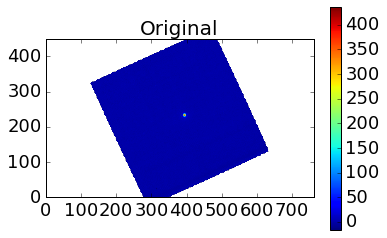

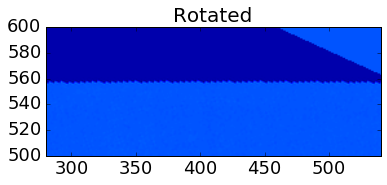

In [442]:
not_aber_path = predir+'image16_minus150.fits'

no_aber = data_manage(path=not_aber_path,angle=24.4)
no_aber_rot = no_aber.rot_img(xlim=(280,540),ylim=(500,600))

Looks like rotating with 24.4 degrees produces the "best" result (i.e. aligned with axes)

---
### Plus 300 nm defocus

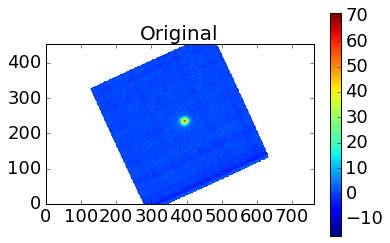

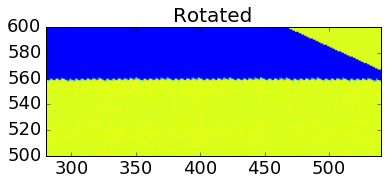

In [78]:
plus_300_path = predir+'image14_plus150.fits'

plus_300 = data_manage(path=plus_300_path,angle=24.4,clipsize=0)
plus_300_rot = plus_300.rot_img(xlim=(280,540),ylim=(500,600))

---
### Plus 100 nm

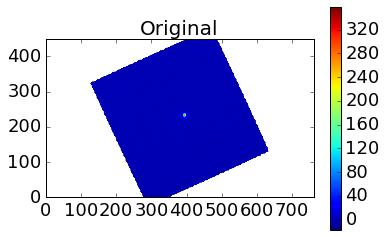

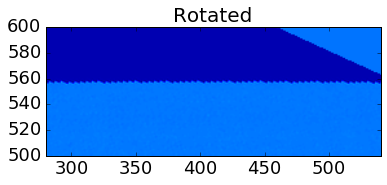

In [116]:
plus_100_path = predir+'image18_minus50.fits'

plus_100 = data_manage(path=plus_100_path,angle=24.4,clipsize=0)
plus_100_rot = plus_100.rot_img(xlim=(280,540),ylim=(500,600))

---
### Ast. 150 nm (and +150nm focus)

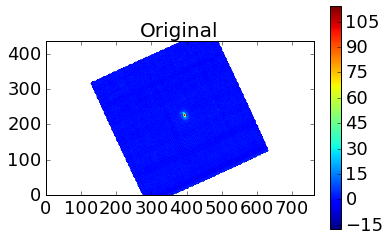

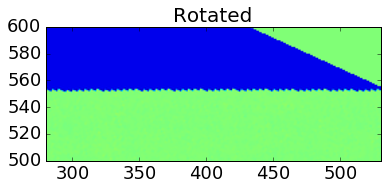

In [80]:
ast_150_path = predir+'image26_astig150.fits'

ast_150 = data_manage(path=ast_150_path,angle=24.4,clipsize=0)
ast_150_rot = ast_150.rot_img(xlim=(280,530),ylim=(500,600))

(336.5, 536.5)

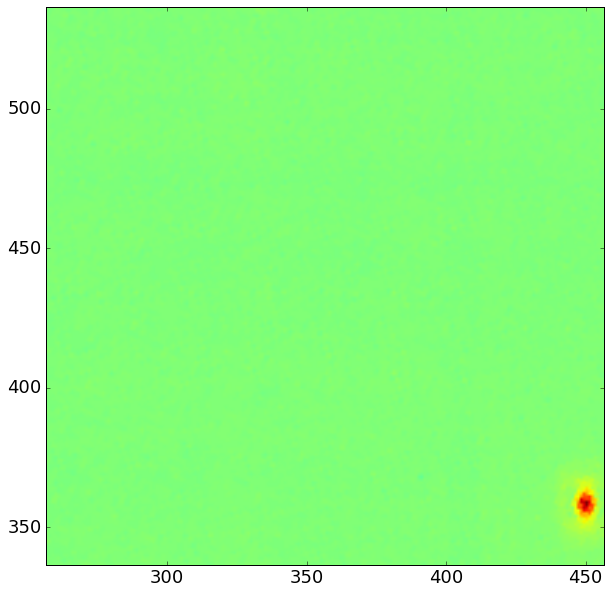

In [86]:
ctx,cty = (ast_150_rot.shape[0]-1)/2.,(ast_150_rot.shape[1]-1)/2.
wd = 100

plt.figure(figsize=(10,10))
plt.imshow(ast_150_rot,origin='lower')
plt.xlim(ctx-wd,ctx+wd); plt.ylim(cty-wd,cty+wd)

Demonstrating that the center has to be found otherwise

---
## <font color="blue">Peak and Center</font>
#### Notes:
1. One potential issue: the interpolation (rotation) has "skewed" the pixels. The reconstruction will certainly be biased.

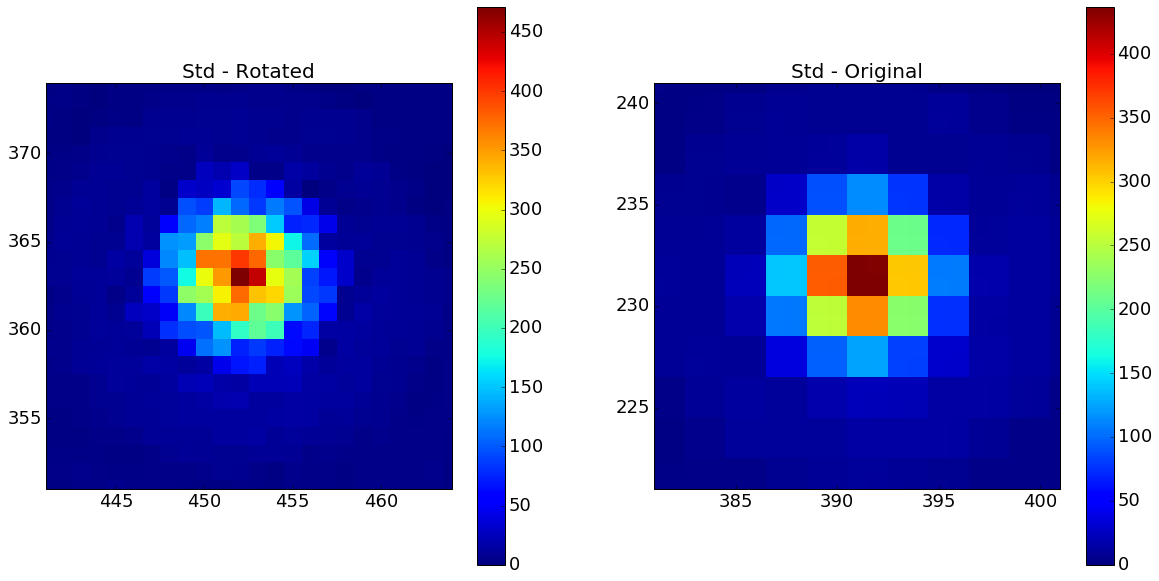

In [285]:
xlim = (441,464)
ylim = (351,374)

xlim2 = (381,401)
ylim2 = (221,241)

##
plt.figure(figsize=(20,10))
plt.subplot(121); plt.title('Std - Rotated')
plt.imshow(no_aber_rot,origin='lower',interpolation='none')
plt.xlim(xlim); plt.ylim(ylim); 
plt.colorbar(); plt.clim(0,np.max(no_aber_rot))

plt.subplot(122); plt.title('Std - Original')
plt.imshow(no_aber.data,origin='lower',interpolation='none')
plt.xlim(xlim2); plt.ylim(ylim2); 
plt.colorbar(); plt.clim(0,np.nanmax(no_aber.data))

FWHM has changed from 6 (note the binning...) to 7...<br>

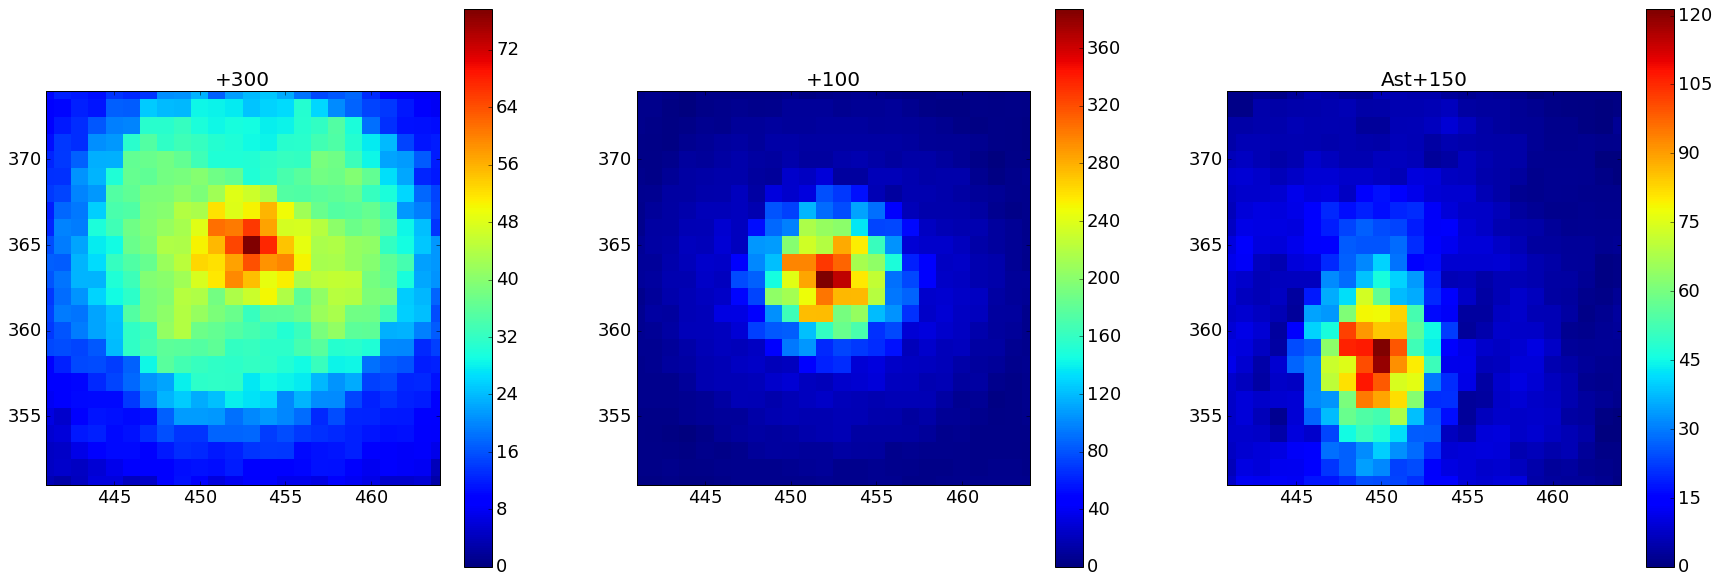

In [287]:
##
plt.figure(figsize=(30,10))
plt.subplot(131); plt.title('+300')
plt.imshow(plus_300_rot,origin='lower',interpolation='none')
plt.xlim(xlim); plt.ylim(ylim); 
plt.colorbar(); plt.clim(0,np.max(plus_300_rot))

plt.subplot(132); plt.title('+100')
plt.imshow(plus_100_rot,origin='lower',interpolation='none')
plt.xlim(xlim); plt.ylim(ylim); 
plt.colorbar(); plt.clim(0,np.max(plus_100_rot))

plt.subplot(133); plt.title('Ast+150')
plt.imshow(ast_150_rot,origin='lower',interpolation='none')
plt.xlim(xlim); plt.ylim(ylim); 
plt.colorbar(); plt.clim(0,np.max(ast_150_rot))

The centers are (453,365), (452,363), and (450,359) respectively

---
## <font color="red">Defining "oversampling" for PR purpose</font>
We know that Airy disk has an FWHM of ~1.2 $\lambda/D$:
<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/e/e1/Airy_vs_gaus.svg/502px-Airy_vs_gaus.svg.png'>

Now since (see also the [notebook](https://nbviewer.jupyter.org/github/Mipanox/GPI_stuff/blob/master/full_opt.ipynb) for optics simulation) the sampling frequnecy ($f_s$) goes as
$$ f_s = \frac{\lambda}{Df_\text{pix}} $$
where $f_\text{pix}$ is the pixel size in the focal plane, in radians; everything else is in physical unit. The total number of pixels required for such $f_s$ is
$$ N_\text{pix} = D_Nf_s $$
where $D_N$ is the diameter of the aperture itself in pixels. Converting these to the "oversampling" rate ($\equiv O_s$) defined in our PR routines (see the [code](https://github.com/Mipanox/GPI_stuff/blob/master/codes/pr.py)), we have
$$ O_s = \frac{N_\text{pix}}{2D_N} = \frac{\lambda}{2Df_\text{pix}}$$

Finally, if the measured FWHM is across $m$ pixels in the focal plane, and because $mf_\text{pix}=1.2\lambda/D$, then
$$ O_s = \frac{m}{2\times1.2} = \frac{m}{2.4} $$


<br><br><br>
In our cases, for example, the oversampling (from rotated images) to input to PR routines is 7/2.4~2.92

---
## <font color="blue">Masking - clipping the images</font>
Two ways: Circular or square. Intuitively I'd prefer circular as these PSFs contain spatial frequency information from the pupil input.

In [277]:
test=np.copy(no_aber_rot)
outtest,outmask = ctr_mask(test,size=30,center=(452,363))

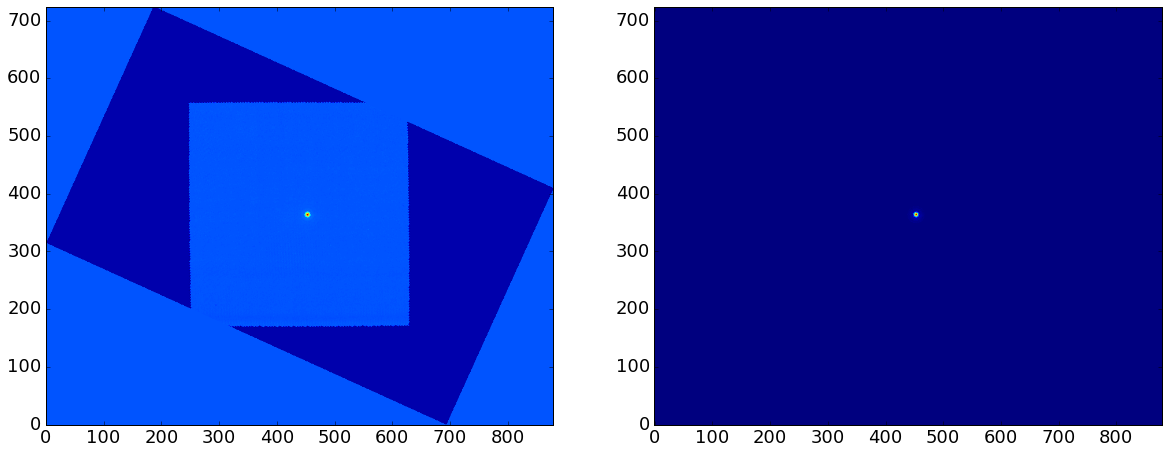

In [278]:
plt.figure(figsize=(20,10))
plt.subplot(121); plt.imshow(no_aber_rot,origin='lower')
plt.subplot(122); plt.imshow(outtest,origin='lower')

In [279]:
clipped = clipping(test,Npix=128,center=(452,363),size=30)

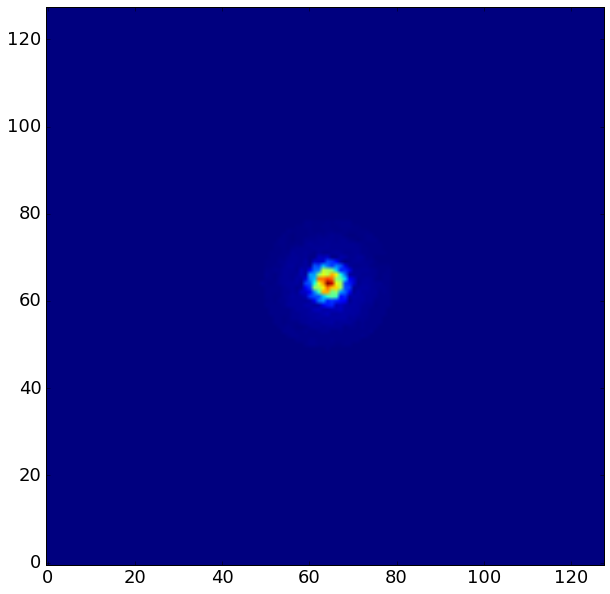

In [280]:
plt.figure(figsize=(10,10))
plt.imshow(clipped,origin='lower')

Clipping and masking in this size should leave us enough information about the PSF

### Applying to all images 

In [301]:
Npix = 512
ctr  = (452,363)
size = 30

##
no_aber_clp  = clipping(no_aber_rot, Npix=Npix,center=(452,363),size=size)
plus_300_clp = clipping(plus_300_rot,Npix=Npix,center=(453,365),size=size,shape='circular')
plus_100_clp = clipping(plus_100_rot,Npix=Npix,center=(452,363),size=size)
ast_150_clp  = clipping(ast_150_rot, Npix=Npix,center=(450,359),size=size)

(220, 290)

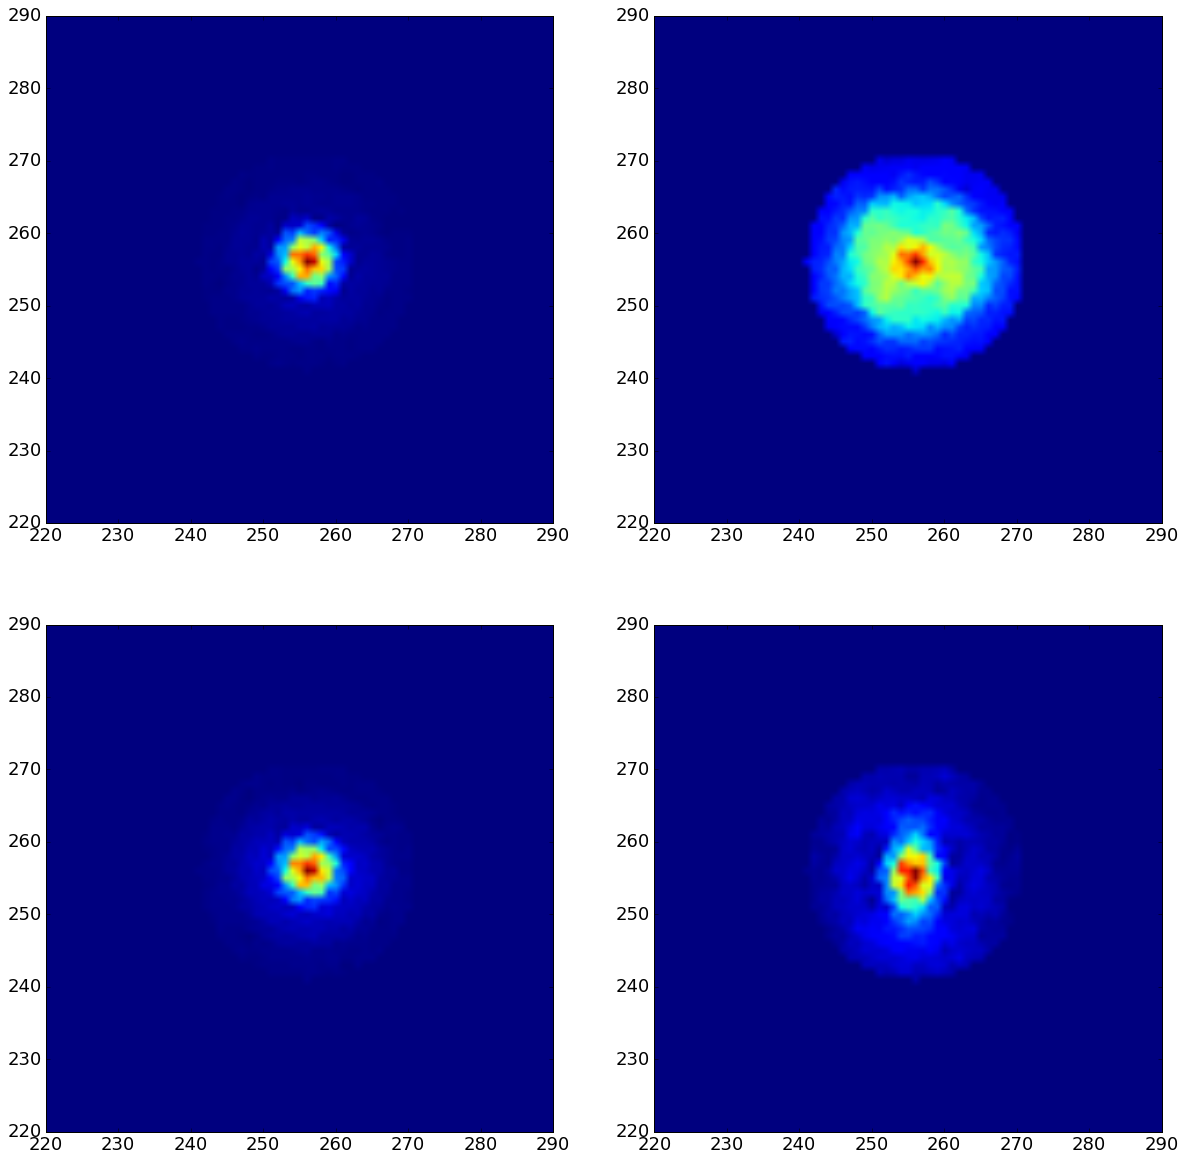

In [302]:
plt.figure(figsize=(20,20))
plt.subplot(221); plt.imshow(no_aber_clp, origin='lower'); plt.xlim(220,290); plt.ylim(220,290)
plt.subplot(222); plt.imshow(plus_300_clp,origin='lower'); plt.xlim(220,290); plt.ylim(220,290)
plt.subplot(223); plt.imshow(plus_100_clp,origin='lower'); plt.xlim(220,290); plt.ylim(220,290)
plt.subplot(224); plt.imshow(ast_150_clp, origin='lower'); plt.xlim(220,290); plt.ylim(220,290)

---
## <font color="orange">PR</font>
#### <font color="cyan">!!! Assumed uniform aperture !!!</font>
#### 1. No-aber

In [362]:
## assume all images were taken under same condition
oversamp = 2.92

## setup
no_aber_PR = PR(foc=no_aber_clp,oversamp=oversamp)

Down-sampled array dimension is not even: 87 pix
 Changed to nearest oversamp: 2.91 that gives even-sized arrays


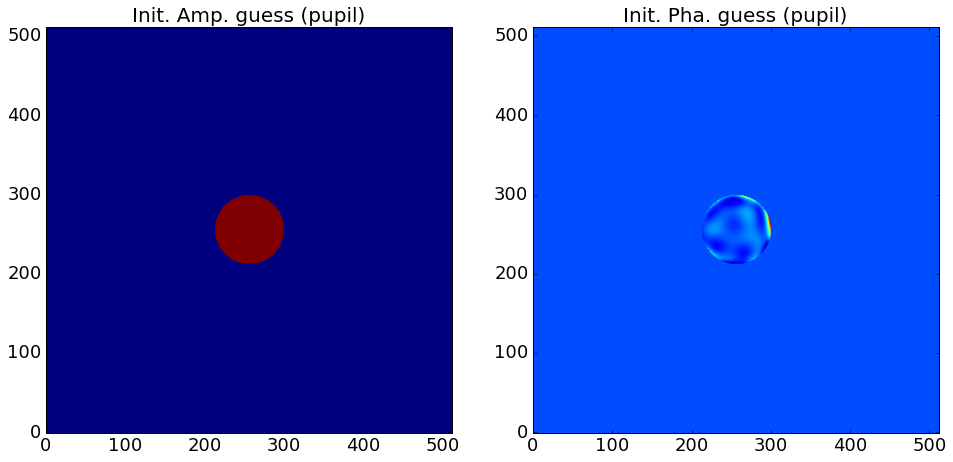

Current filter:


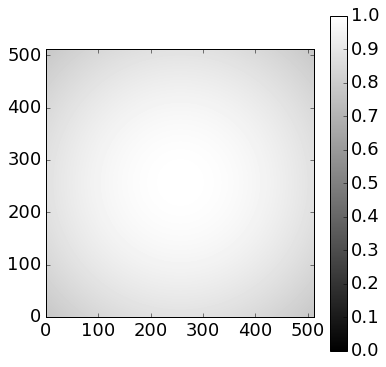

Current iter. : 100
        Error : 1.82e-02
Current iter. : 200
        Error : 1.82e-02
Current filter:


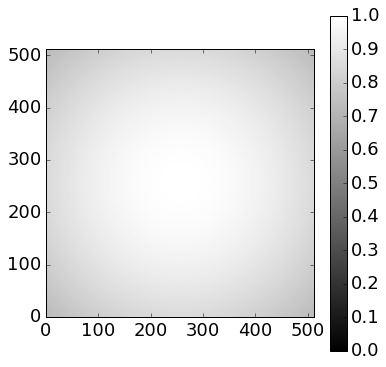

Current iter. : 300
        Error : 1.82e-02
Current iter. : 400
        Error : 1.82e-02
Current filter:


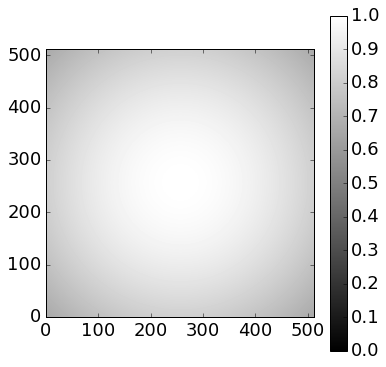

Current iter. : 500
        Error : 1.82e-02
Current iter. : 600
        Error : 1.82e-02
Current filter:


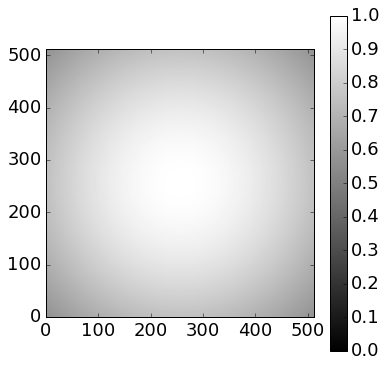

Current iter. : 700
        Error : 1.82e-02
Current iter. : 800
        Error : 1.82e-02
Current filter:


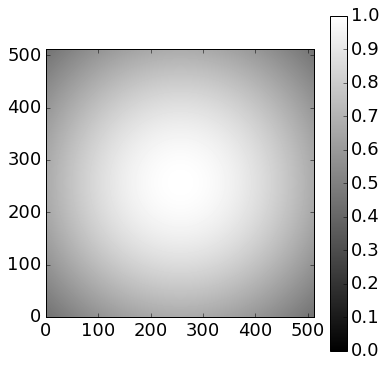

Current iter. : 900
        Error : 1.82e-02
Current iter. : 1000
        Error : 1.82e-02
Current filter:


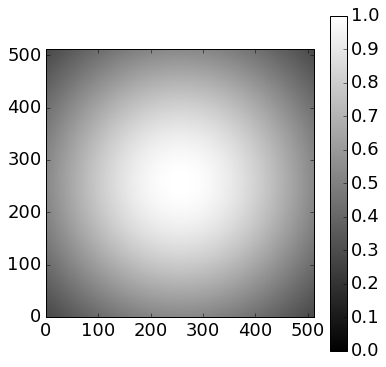

Current iter. : 1100
        Error : 1.82e-02
Current iter. : 1200
        Error : 1.82e-02
Current filter:


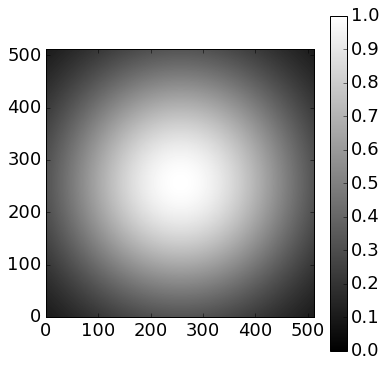

Current iter. : 1300
        Error : 1.82e-02
Current iter. : 1400
        Error : 1.82e-02
Current filter:


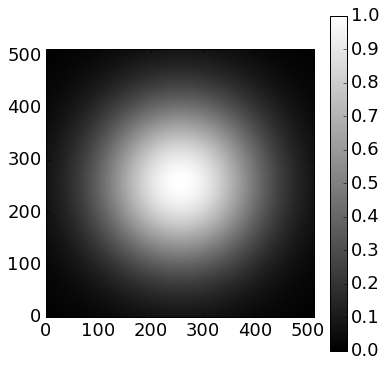

Current iter. : 1500
        Error : 1.82e-02
Current iter. : 1600
        Error : 1.82e-02
Current filter:


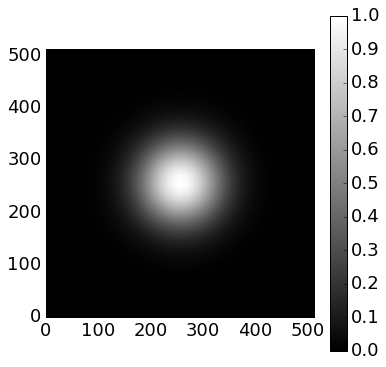

Current iter. : 1700
        Error : 1.82e-02
Current iter. : 1800
        Error : 1.82e-02
Current filter:


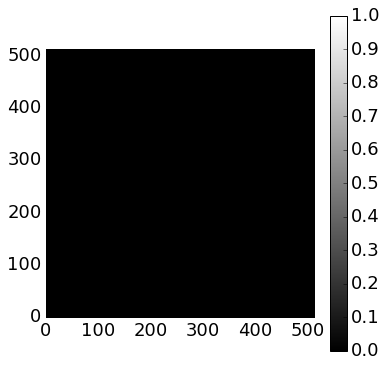

Current iter. : 1900
        Error : 1.82e-02
Current iter. : 2000
        Error : 1.82e-02
-----------------------
First iteration error: 5.93e-02
Final iteration : 2000
Final Error: 1.82e-02


In [363]:
no_aber_pup,no_aber_foc, \
no_aber_errlist, \
no_aber_pup_proj, \
no_aber_errpuplist = no_aber_PR.OSS(beta=0.5,force_only_phase=True,init='random')

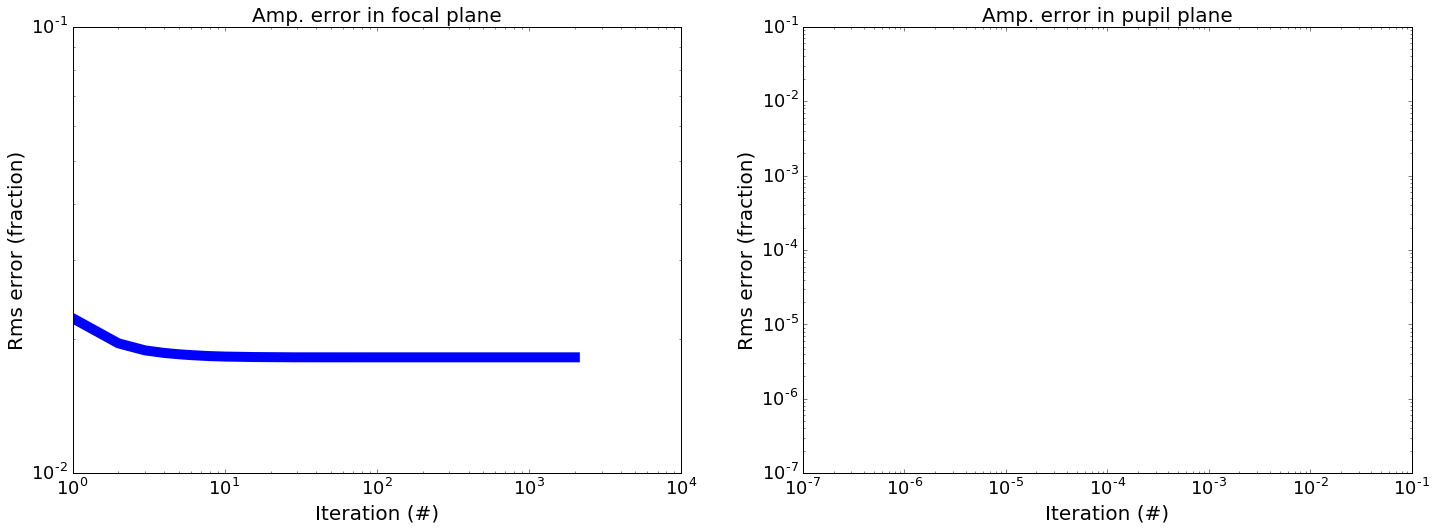

In [364]:
plot_errlist(no_aber_errlist,no_aber_errpuplist)

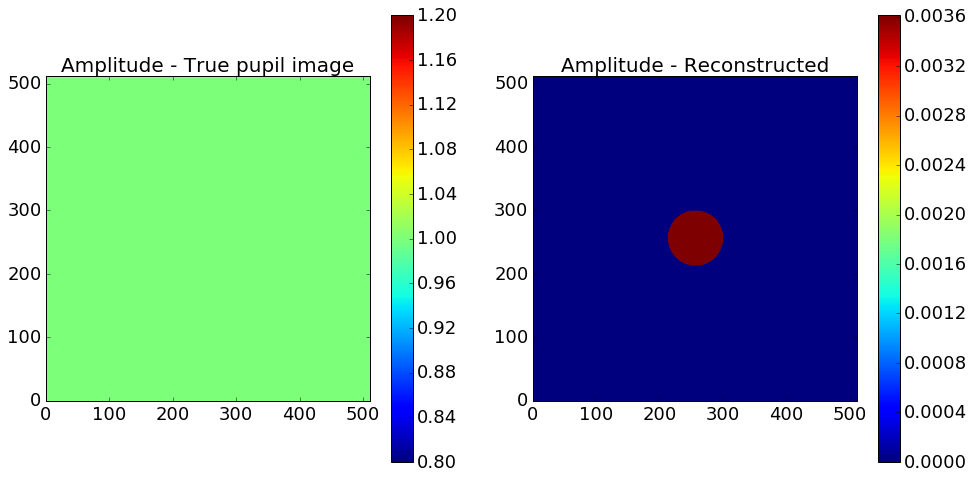

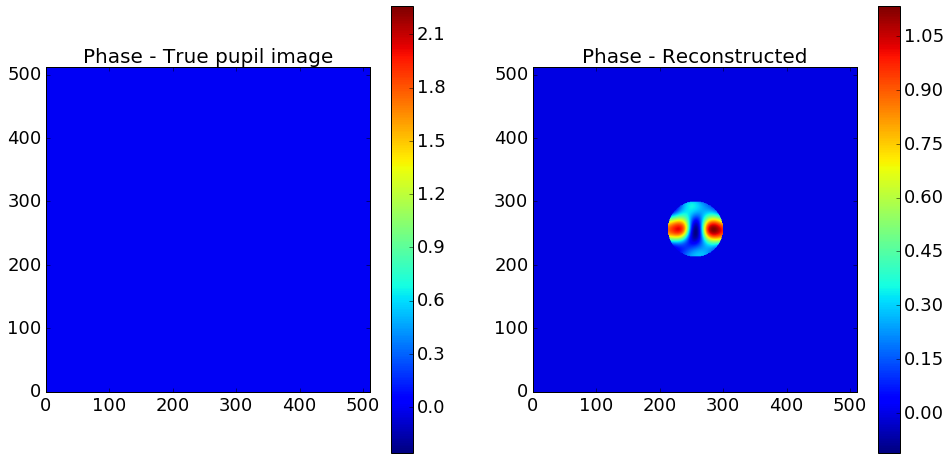

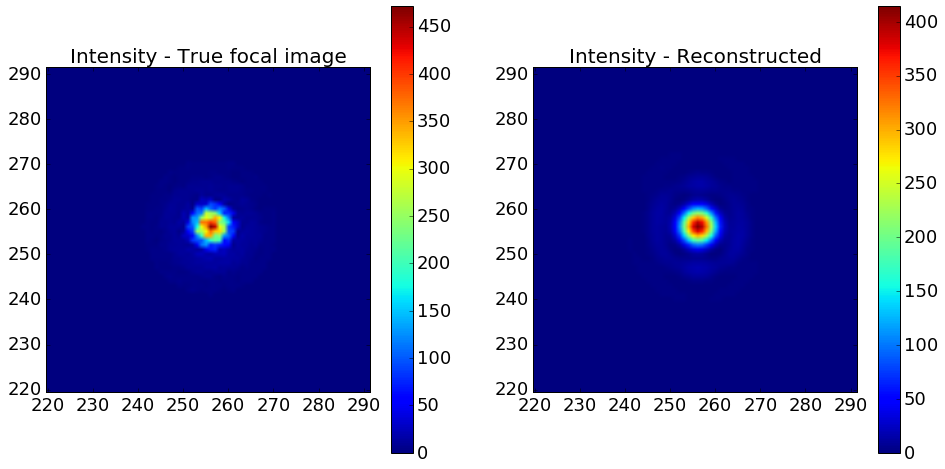

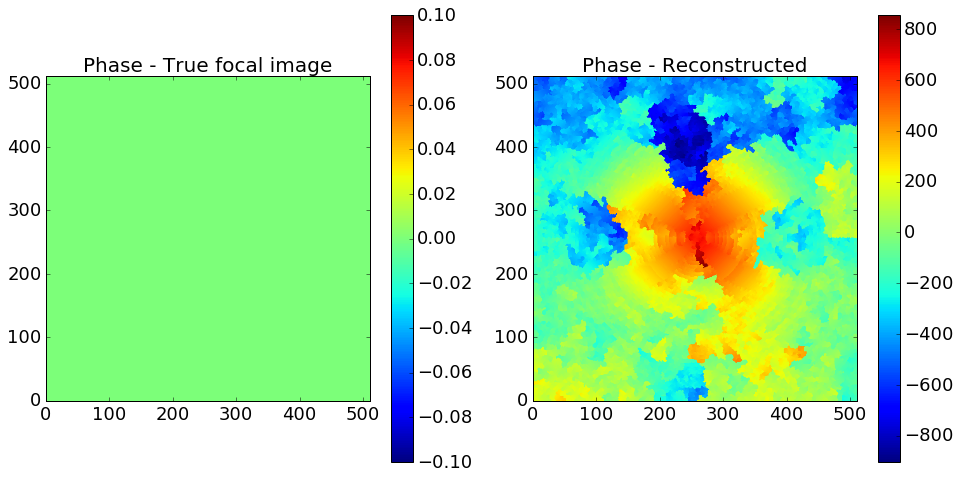

In [397]:
plot_recon(np.ones((Npix,Npix)),np.sqrt(no_aber_PR.foc),no_aber_pup_proj,no_aber_foc)

#### 2. Plus 300nm

In [366]:
plus_300_PR = PR(foc=plus_300_clp,oversamp=oversamp)

Down-sampled array dimension is not even: 87 pix
 Changed to nearest oversamp: 2.91 that gives even-sized arrays


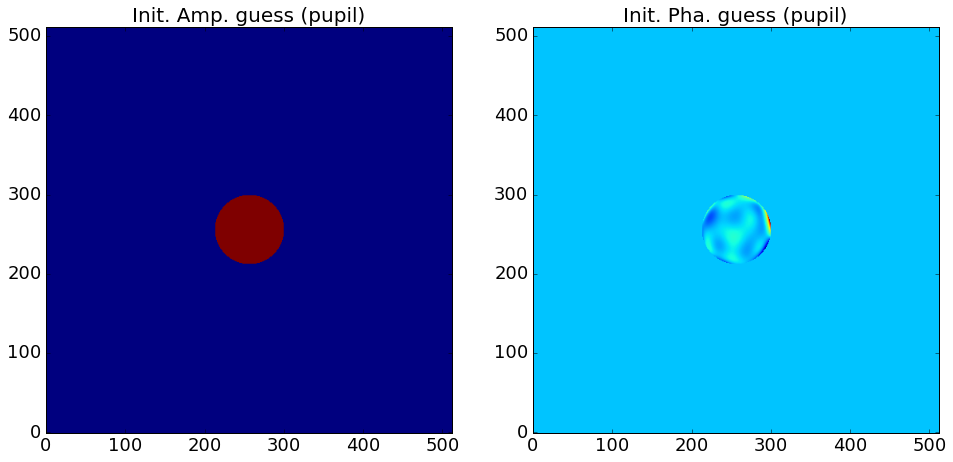

Current filter:


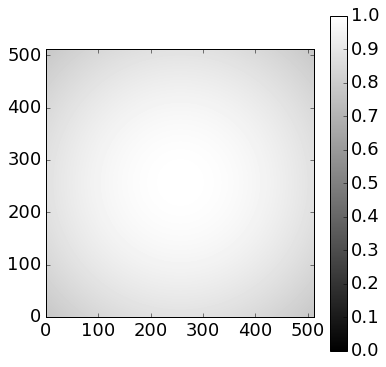

Current iter. : 100
        Error : 1.72e-02
Current iter. : 200
        Error : 1.71e-02
Current filter:


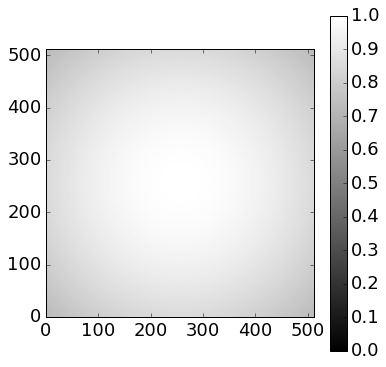

Current iter. : 300
        Error : 1.71e-02
Current iter. : 400
        Error : 1.71e-02
Current filter:


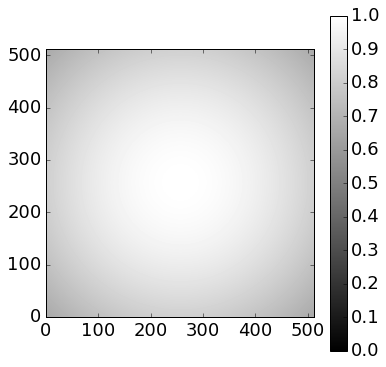

Current iter. : 500
        Error : 1.71e-02
Current iter. : 600
        Error : 1.71e-02
Current filter:


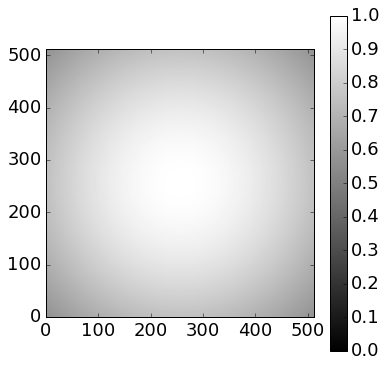

Current iter. : 700
        Error : 1.71e-02
Current iter. : 800
        Error : 1.71e-02
Current filter:


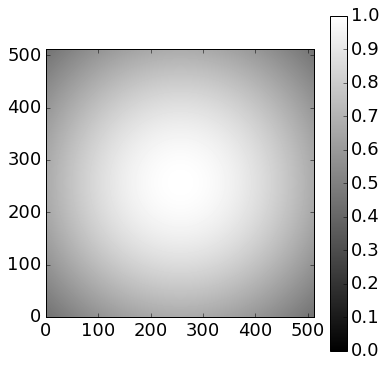

Current iter. : 900
        Error : 1.71e-02
Current iter. : 1000
        Error : 1.71e-02
Current filter:


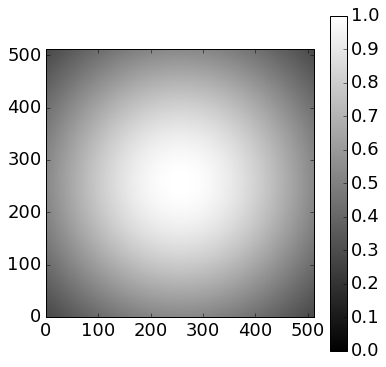

Current iter. : 1100
        Error : 1.71e-02
Current iter. : 1200
        Error : 1.71e-02
Current filter:


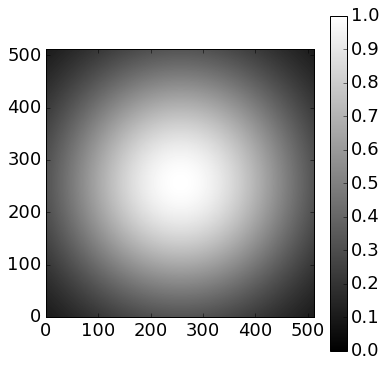

Current iter. : 1300
        Error : 1.71e-02
Current iter. : 1400
        Error : 1.71e-02
Current filter:


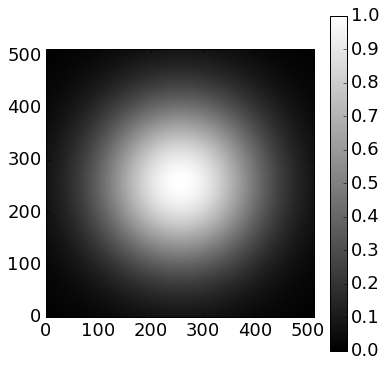

Current iter. : 1500
        Error : 1.71e-02
Current iter. : 1600
        Error : 1.71e-02
Current filter:


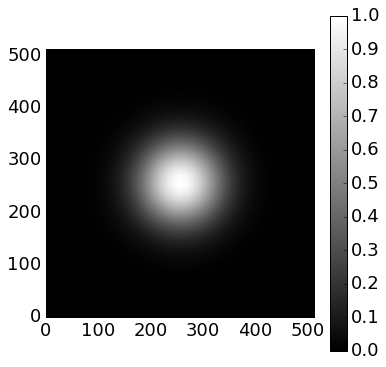

Current iter. : 1700
        Error : 1.71e-02
Current iter. : 1800
        Error : 1.71e-02
Current filter:


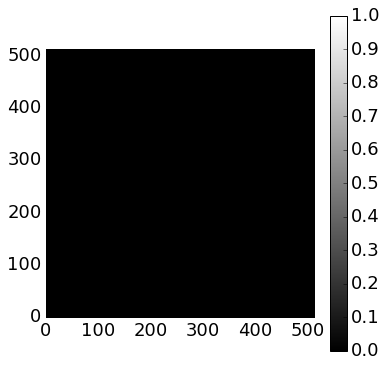

Current iter. : 1900
        Error : 1.71e-02
Current iter. : 2000
        Error : 1.71e-02
-----------------------
First iteration error: 4.22e-02
Final iteration : 2000
Final Error: 1.71e-02


In [368]:
plus_300_pup,plus_300_foc, \
plus_300_errlist, \
plus_300_pup_proj, \
plus_300_errpuplist = plus_300_PR.OSS(beta=0.5,force_only_phase=True,init='random')

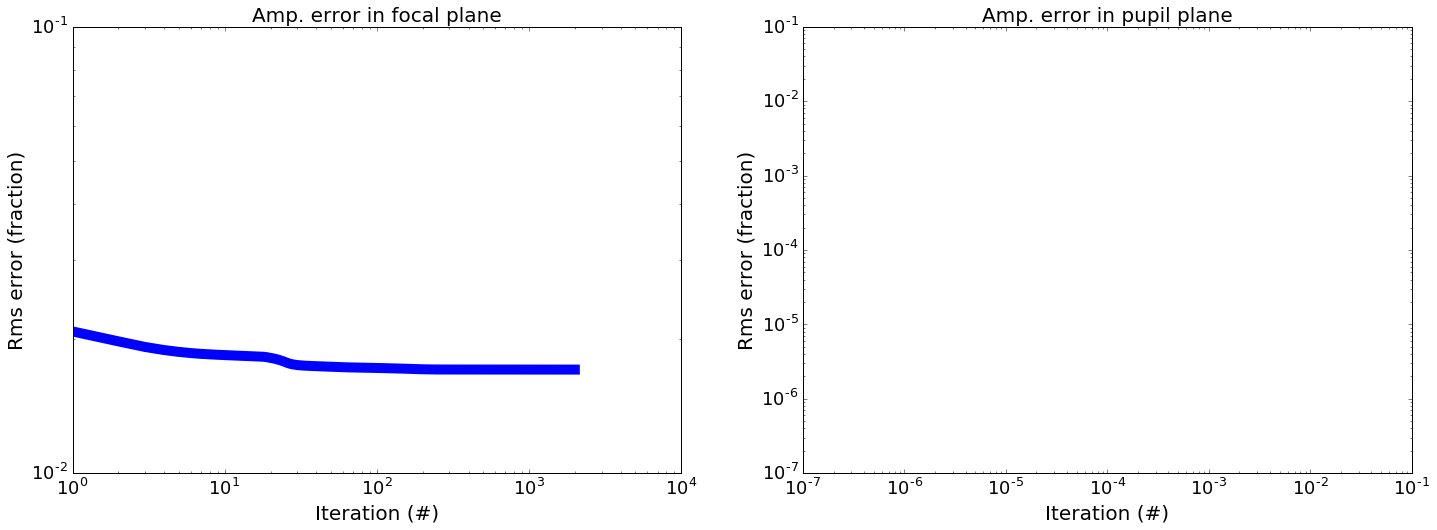

In [369]:
plot_errlist(plus_300_errlist,plus_300_errpuplist)

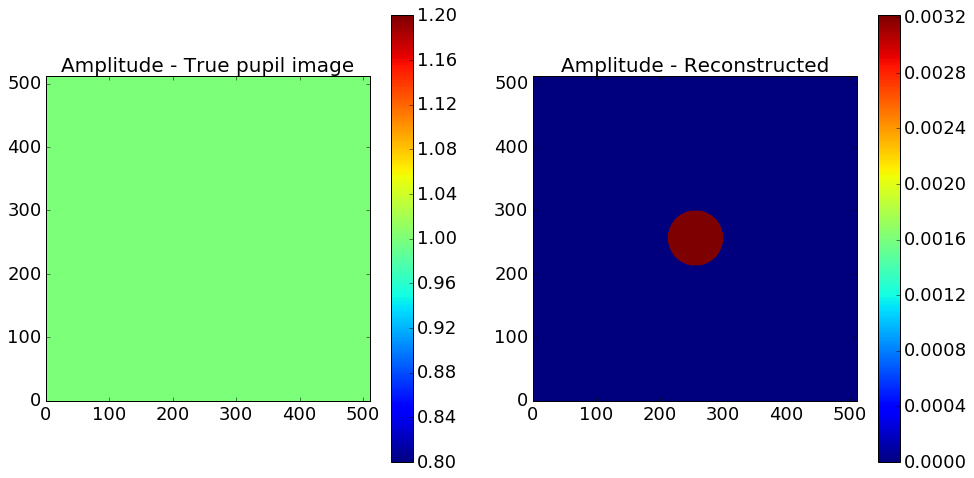

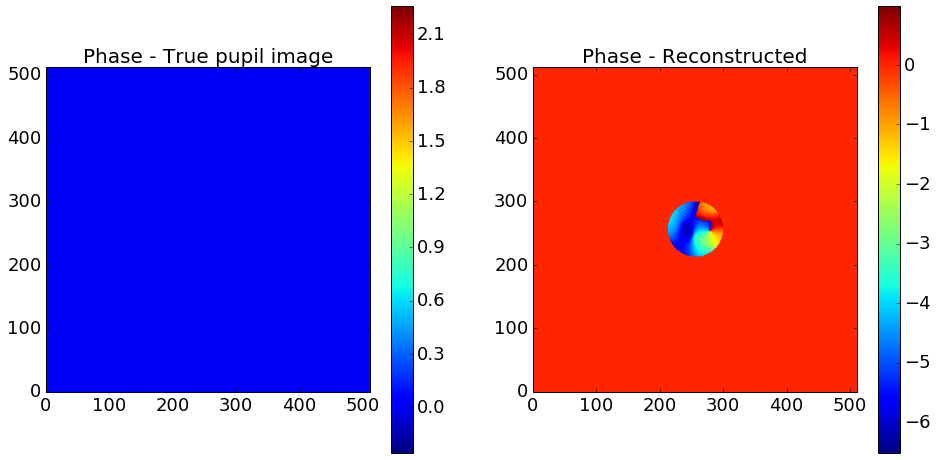

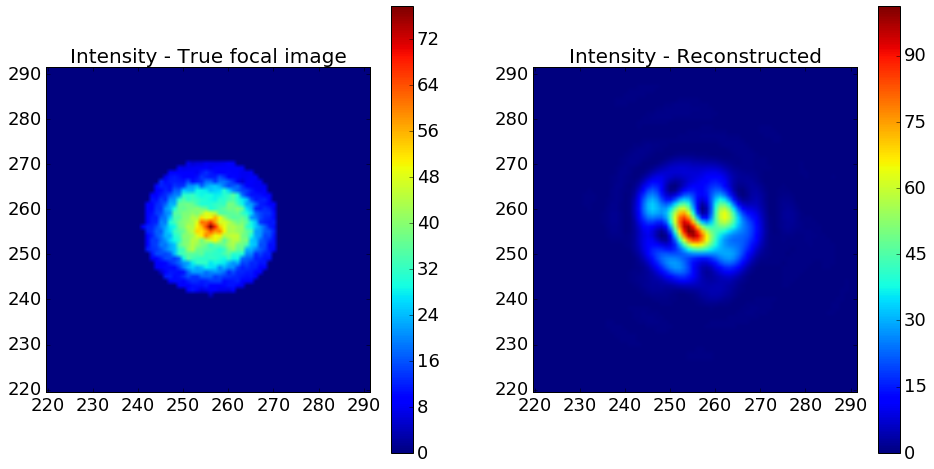

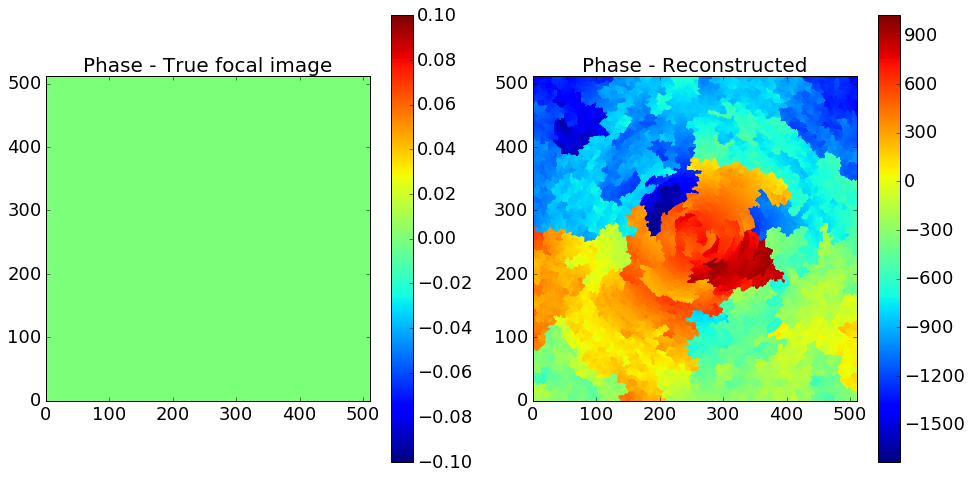

In [396]:
plot_recon(np.ones((Npix,Npix)),np.sqrt(plus_300_PR.foc),plus_300_pup_proj,plus_300_foc)

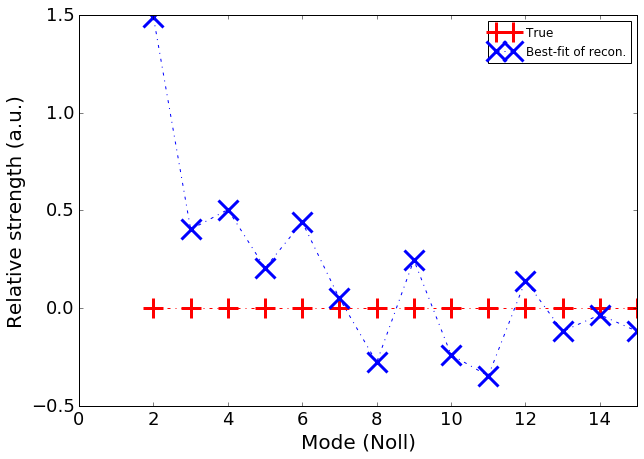

In [418]:
coef_plus_300_true, \
coef_plus_300_reco = wrap_up_zern_fit(plus_300_PR,
                                      Recon_phasor=plus_300_pup_proj,
                                      P_phasor=np.zeros((512,512)),
                                      oversamp=2.90)

Tilt...Not focus

#### 3. Ast. 150nm

In [398]:
ast_150_PR = PR(foc=ast_150_clp,oversamp=oversamp)

Down-sampled array dimension is not even: 87 pix
 Changed to nearest oversamp: 2.91 that gives even-sized arrays


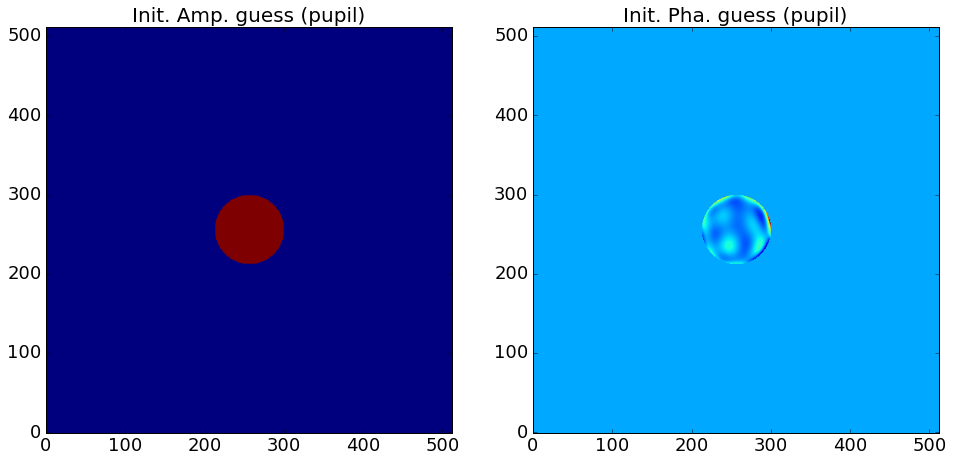

Current filter:


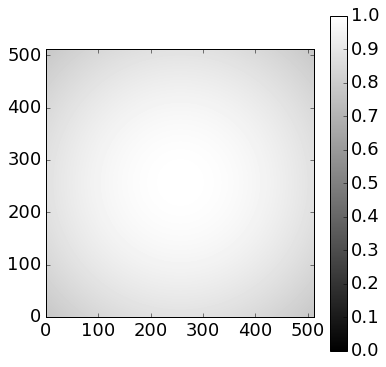

Current iter. : 100
        Error : 1.61e-02
Current iter. : 200
        Error : 1.61e-02
Current filter:


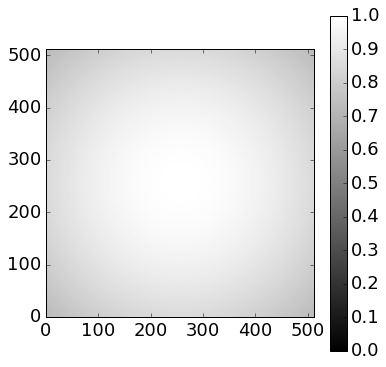

Current iter. : 300
        Error : 1.61e-02
Current iter. : 400
        Error : 1.61e-02
Current filter:


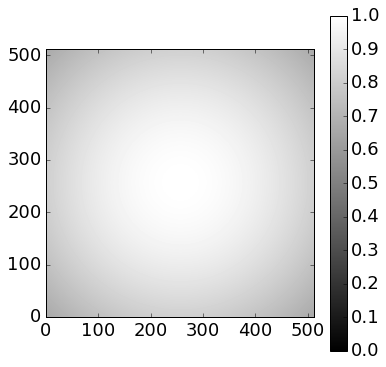

Current iter. : 500
        Error : 1.61e-02
Current iter. : 600
        Error : 1.61e-02
Current filter:


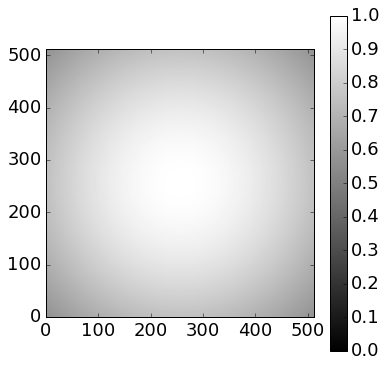

Current iter. : 700
        Error : 1.61e-02
Current iter. : 800
        Error : 1.61e-02
Current filter:


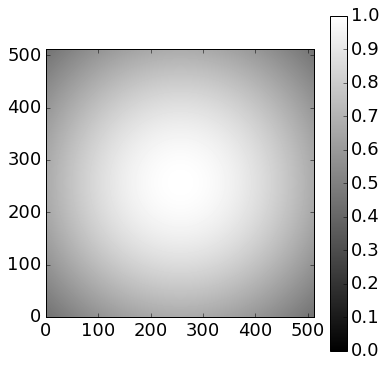

Current iter. : 900
        Error : 1.61e-02
Current iter. : 1000
        Error : 1.61e-02
Current filter:


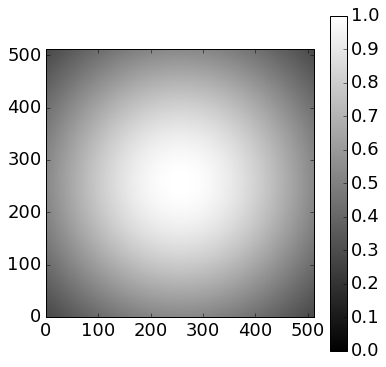

Current iter. : 1100
        Error : 1.61e-02
Current iter. : 1200
        Error : 1.61e-02
Current filter:


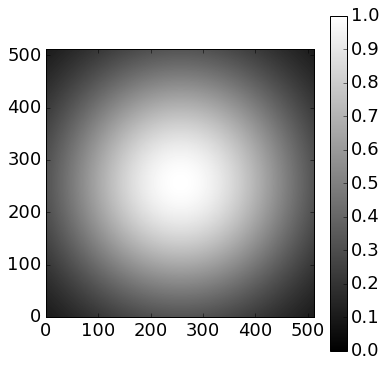

Current iter. : 1300
        Error : 1.61e-02
Current iter. : 1400
        Error : 1.61e-02
Current filter:


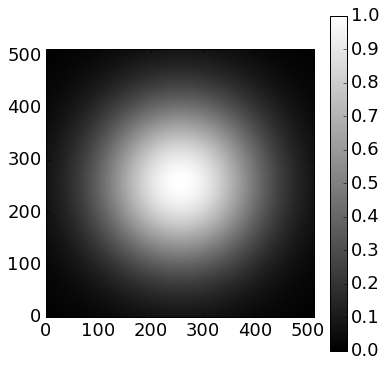

Current iter. : 1500
        Error : 1.61e-02
Current iter. : 1600
        Error : 1.61e-02
Current filter:


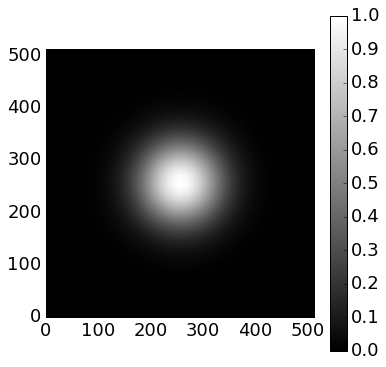

Current iter. : 1700
        Error : 1.61e-02
Current iter. : 1800
        Error : 1.61e-02
Current filter:


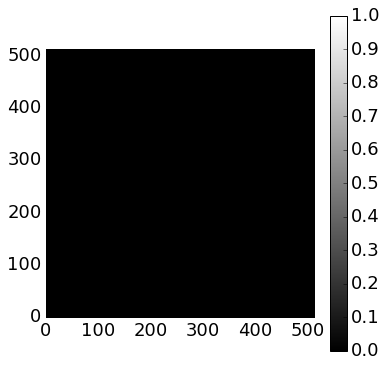

Current iter. : 1900
        Error : 1.61e-02
Current iter. : 2000
        Error : 1.61e-02
-----------------------
First iteration error: 4.76e-02
Final iteration : 2000
Final Error: 1.61e-02


In [399]:
ast_150_pup,ast_150_foc, \
ast_150_errlist, \
ast_150_pup_proj, \
ast_150_errpuplist = ast_150_PR.OSS(beta=0.5,force_only_phase=True,init='random')

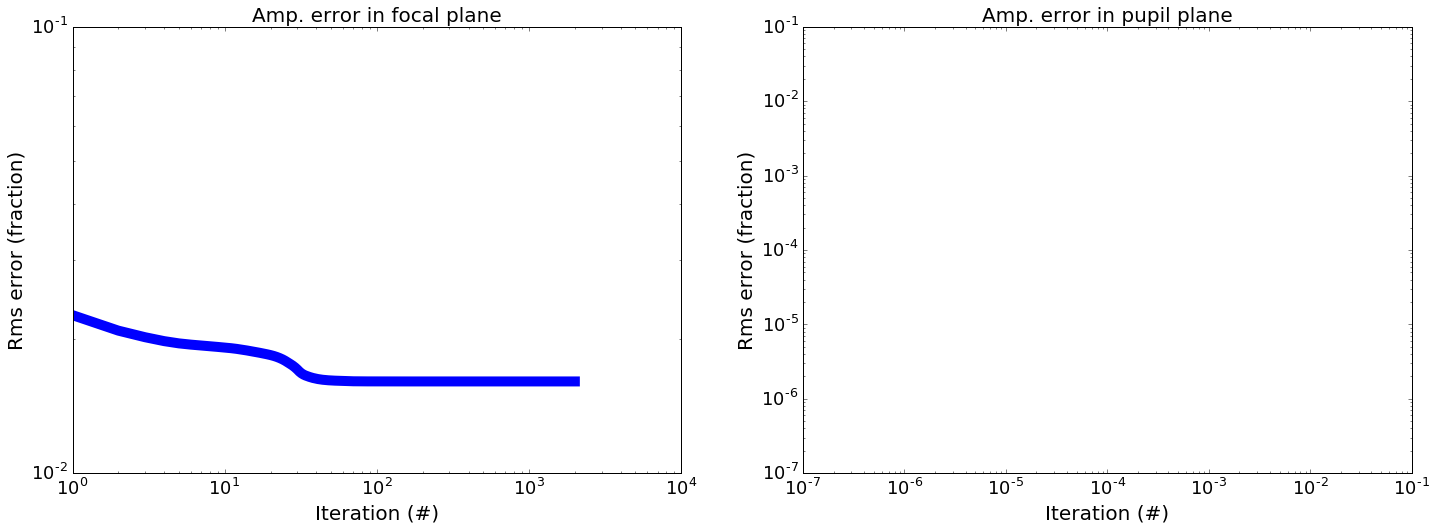

In [400]:
plot_errlist(ast_150_errlist,ast_150_errpuplist)

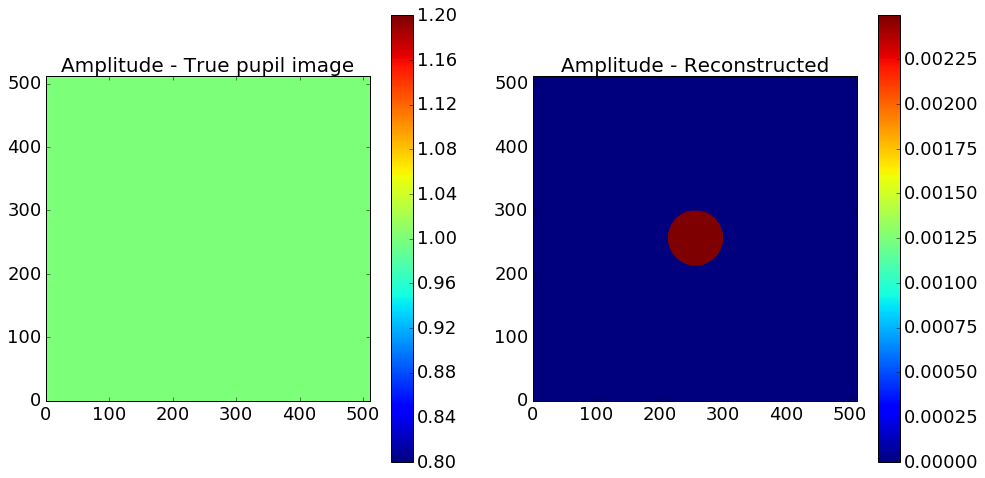

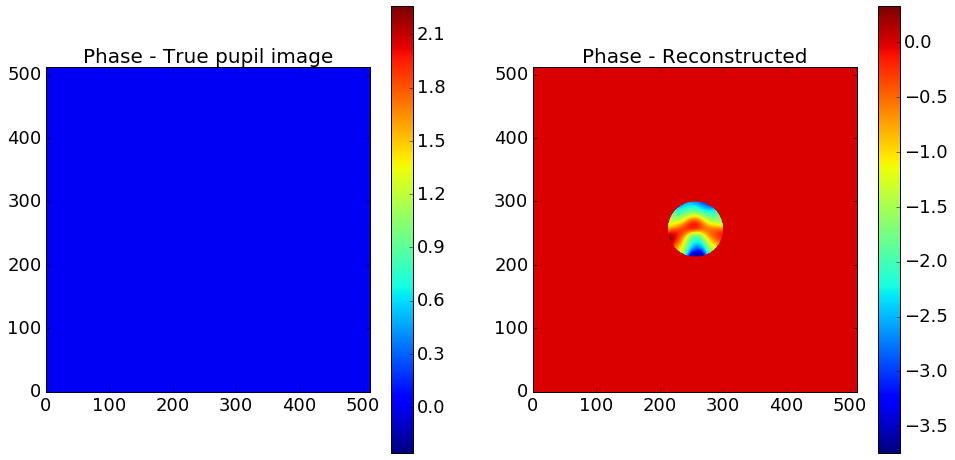

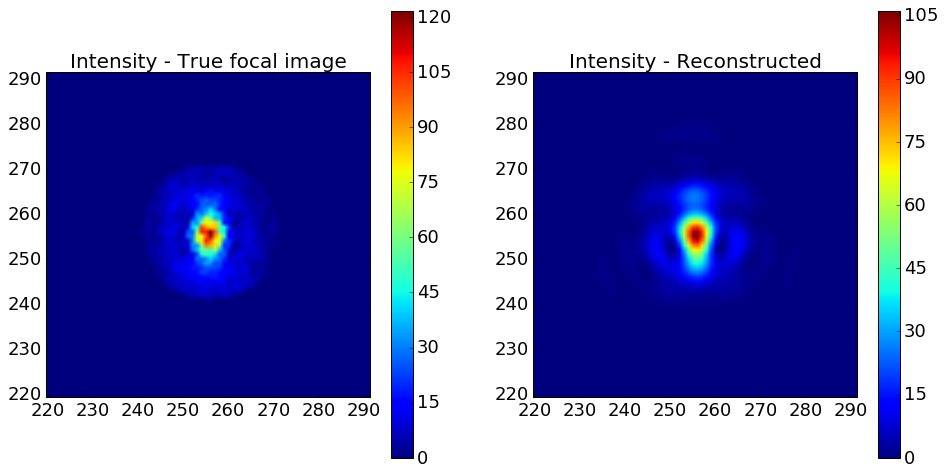

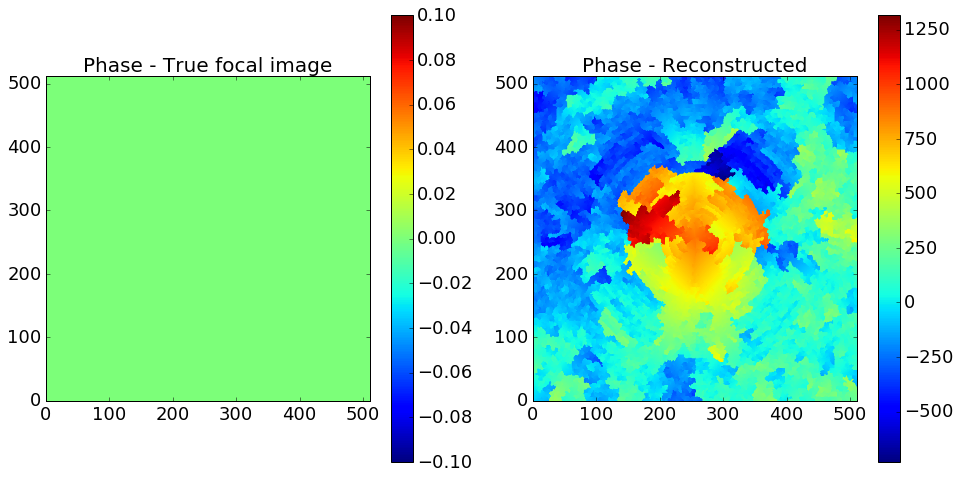

In [403]:
plot_recon(np.ones((Npix,Npix)),np.sqrt(ast_150_PR.foc),ast_150_pup_proj,ast_150_foc)

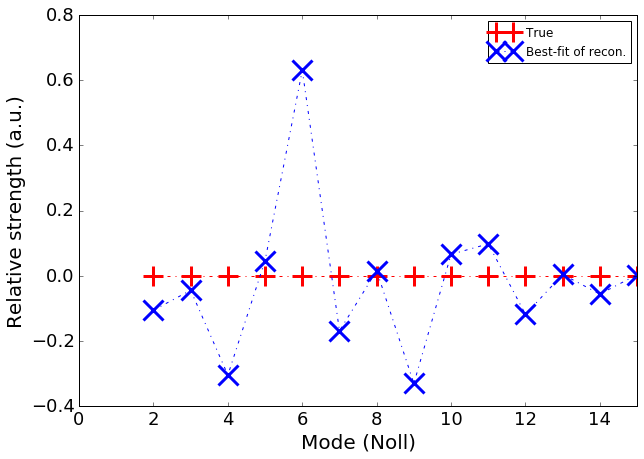

In [416]:
coef_ast_150_true, \
coef_ast_150_reco = wrap_up_zern_fit(ast_150_PR,
                                     Recon_phasor=ast_150_pup_proj,
                                     P_phasor=np.zeros((512,512)),
                                     oversamp=2.90)

Good. We know the data was generated from 150nm focus and 150nm astigmatism!

### How about the "original" PSFs?
_i.e. without rotation..._

#### Centers

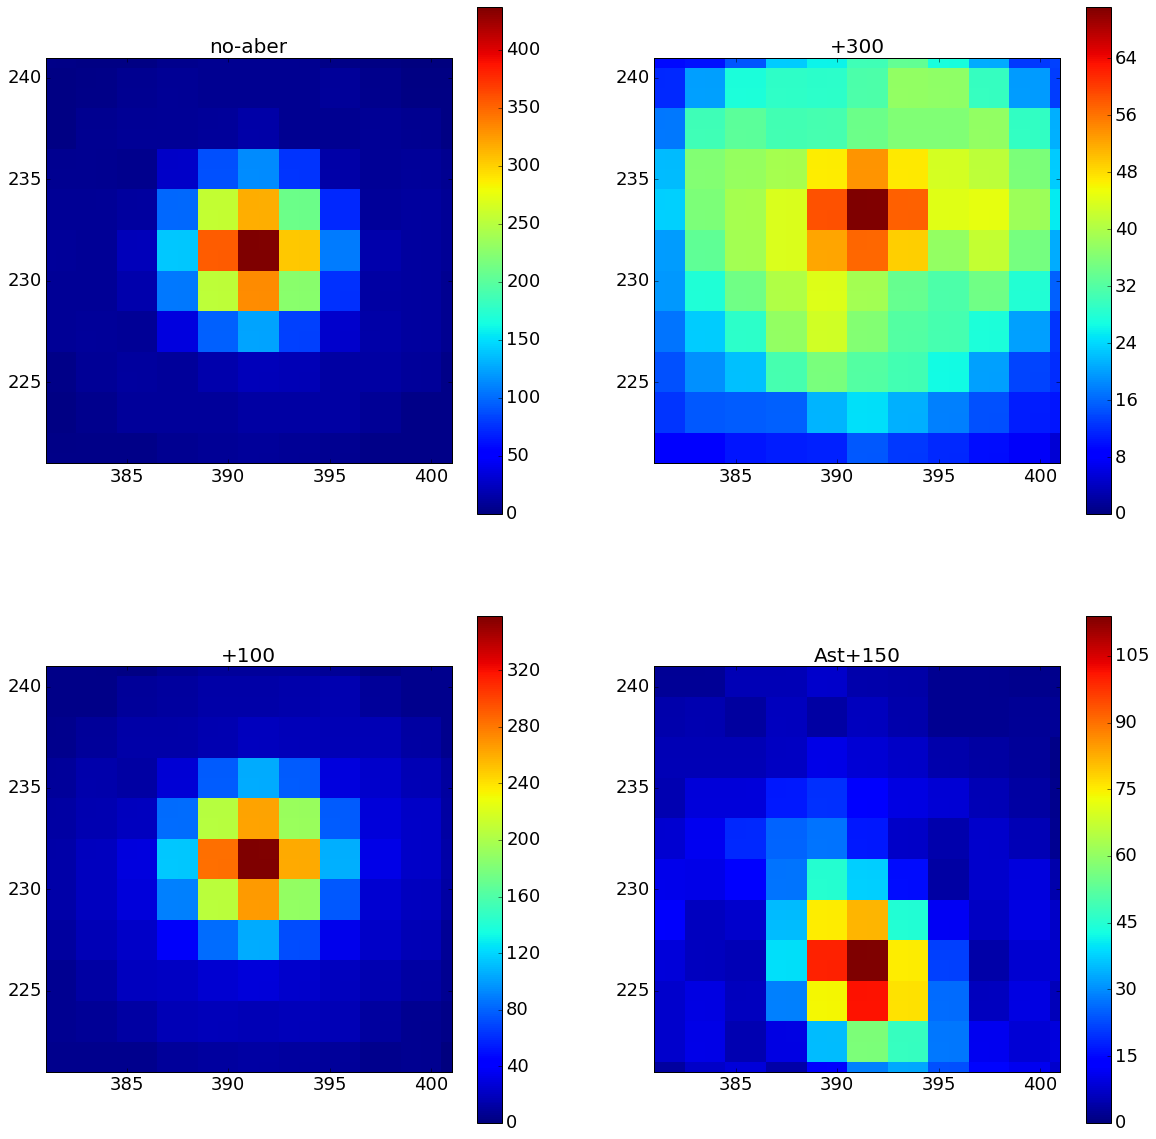

In [417]:
##
plt.figure(figsize=(20,20))
plt.subplot(221); plt.title('no-aber')
plt.imshow(no_aber.data,origin='lower',interpolation='none')
plt.xlim(xlim2); plt.ylim(ylim2); 
plt.colorbar(); plt.clim(0,np.nanmax(no_aber.data))

plt.subplot(222); plt.title('+300')
plt.imshow(plus_300.data,origin='lower',interpolation='none')
plt.xlim(xlim2); plt.ylim(ylim2); 
plt.colorbar(); plt.clim(0,np.nanmax(plus_300.data))

plt.subplot(223); plt.title('+100')
plt.imshow(plus_100.data,origin='lower',interpolation='none')
plt.xlim(xlim2); plt.ylim(ylim2); 
plt.colorbar(); plt.clim(0,np.nanmax(plus_100.data))

plt.subplot(224); plt.title('Ast+150')
plt.imshow(ast_150.data,origin='lower',interpolation='none')
plt.xlim(xlim2); plt.ylim(ylim2); 
plt.colorbar(); plt.clim(0,np.nanmax(ast_150.data))

In [421]:
size=40
no_aber_ori_clp  = clipping(no_aber.data, Npix=Npix,center=(391,231),size=size)
plus_300_ori_clp = clipping(plus_300.data,Npix=Npix,center=(391,233),size=size,shape='circular')
plus_100_ori_clp = clipping(plus_100.data,Npix=Npix,center=(391,231),size=size)
ast_150_ori_clp  = clipping(ast_150.data, Npix=Npix,center=(391,226),size=size)

(220, 290)

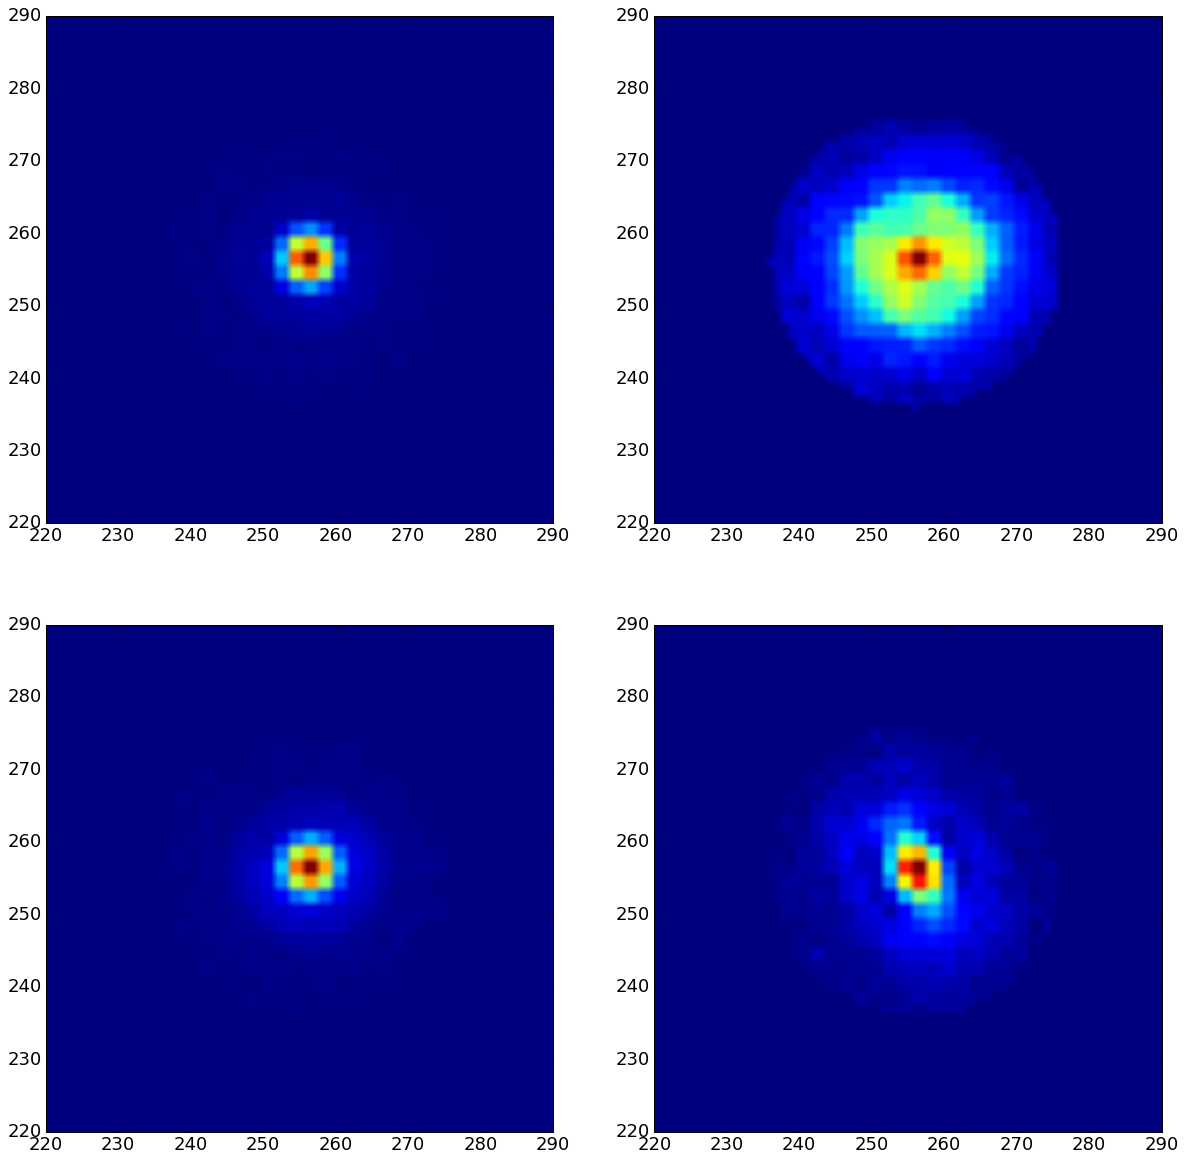

In [422]:
plt.figure(figsize=(20,20))
plt.subplot(221); plt.imshow(no_aber_ori_clp, origin='lower'); plt.xlim(220,290); plt.ylim(220,290)
plt.subplot(222); plt.imshow(plus_300_ori_clp,origin='lower'); plt.xlim(220,290); plt.ylim(220,290)
plt.subplot(223); plt.imshow(plus_100_ori_clp,origin='lower'); plt.xlim(220,290); plt.ylim(220,290)
plt.subplot(224); plt.imshow(ast_150_ori_clp, origin='lower'); plt.xlim(220,290); plt.ylim(220,290)

### Then go...
#### 1. no-aber

In [423]:
## assume all images were taken under same condition
oversamp = 2.92

## setup
no_aber_ori_PR = PR(foc=no_aber_ori_clp,oversamp=oversamp)

Down-sampled array dimension is not even: 87 pix
 Changed to nearest oversamp: 2.91 that gives even-sized arrays


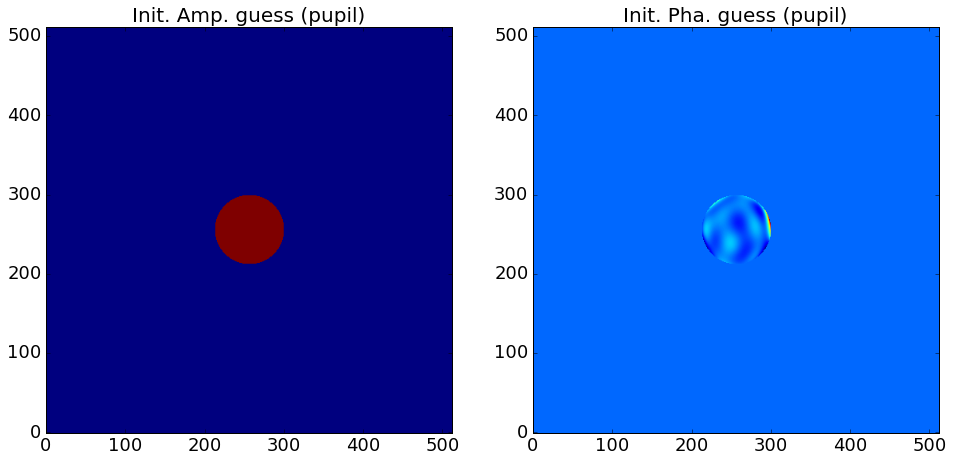

Current filter:


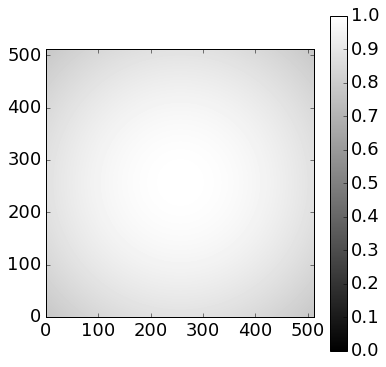

Current iter. : 100
        Error : 1.33e-02
Current iter. : 200
        Error : 1.33e-02
Current filter:


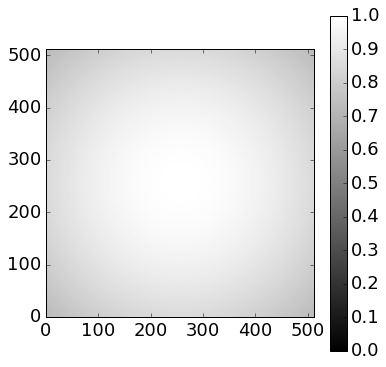

Current iter. : 300
        Error : 1.33e-02
Current iter. : 400
        Error : 1.33e-02
Current filter:


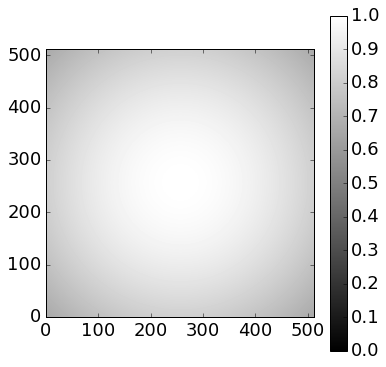

Current iter. : 500
        Error : 1.33e-02
Current iter. : 600
        Error : 1.33e-02
Current filter:


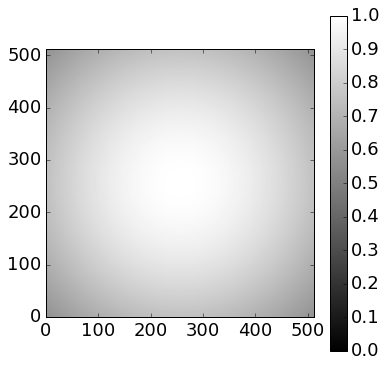

Current iter. : 700
        Error : 1.33e-02
Current iter. : 800
        Error : 1.33e-02
Current filter:


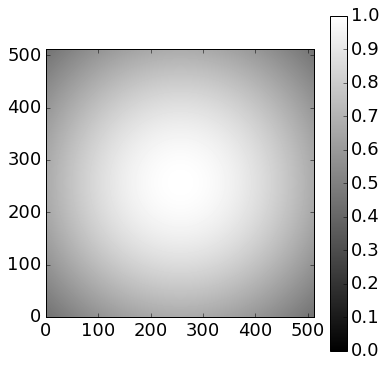

Current iter. : 900
        Error : 1.33e-02
Current iter. : 1000
        Error : 1.33e-02
Current filter:


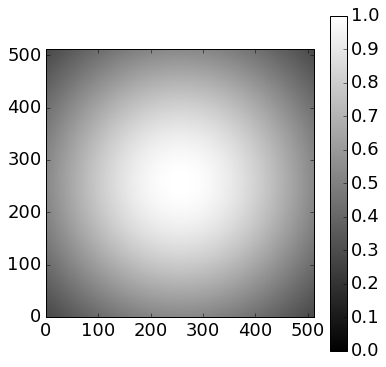

Current iter. : 1100
        Error : 1.33e-02
Current iter. : 1200
        Error : 1.33e-02
Current filter:


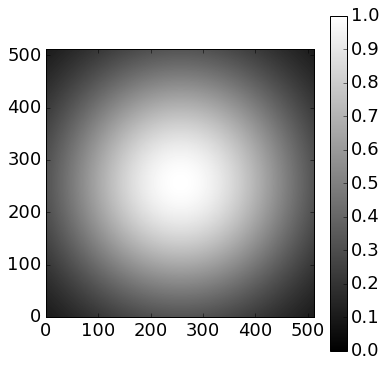

Current iter. : 1300
        Error : 1.33e-02
Current iter. : 1400
        Error : 1.33e-02
Current filter:


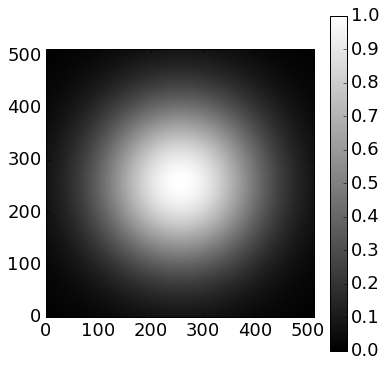

Current iter. : 1500
        Error : 1.33e-02
Current iter. : 1600
        Error : 1.33e-02
Current filter:


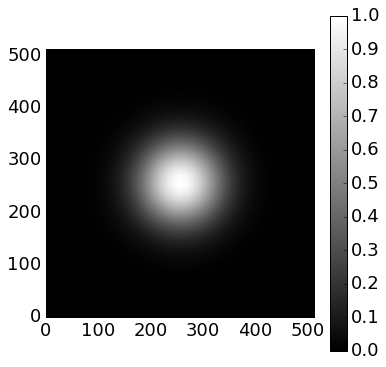

Current iter. : 1700
        Error : 1.33e-02
Current iter. : 1800
        Error : 1.33e-02
Current filter:


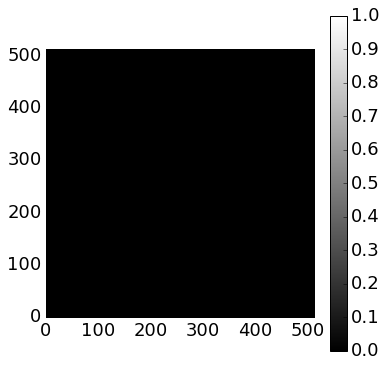

Current iter. : 1900
        Error : 1.33e-02
Current iter. : 2000
        Error : 1.33e-02
-----------------------
First iteration error: 4.60e-02
Final iteration : 2000
Final Error: 1.33e-02


In [424]:
no_aber_ori_pup,no_aber_ori_foc, \
no_aber_ori_errlist, \
no_aber_ori_pup_proj, \
no_aber_ori_errpuplist = no_aber_ori_PR.OSS(beta=0.5,force_only_phase=True,init='random')

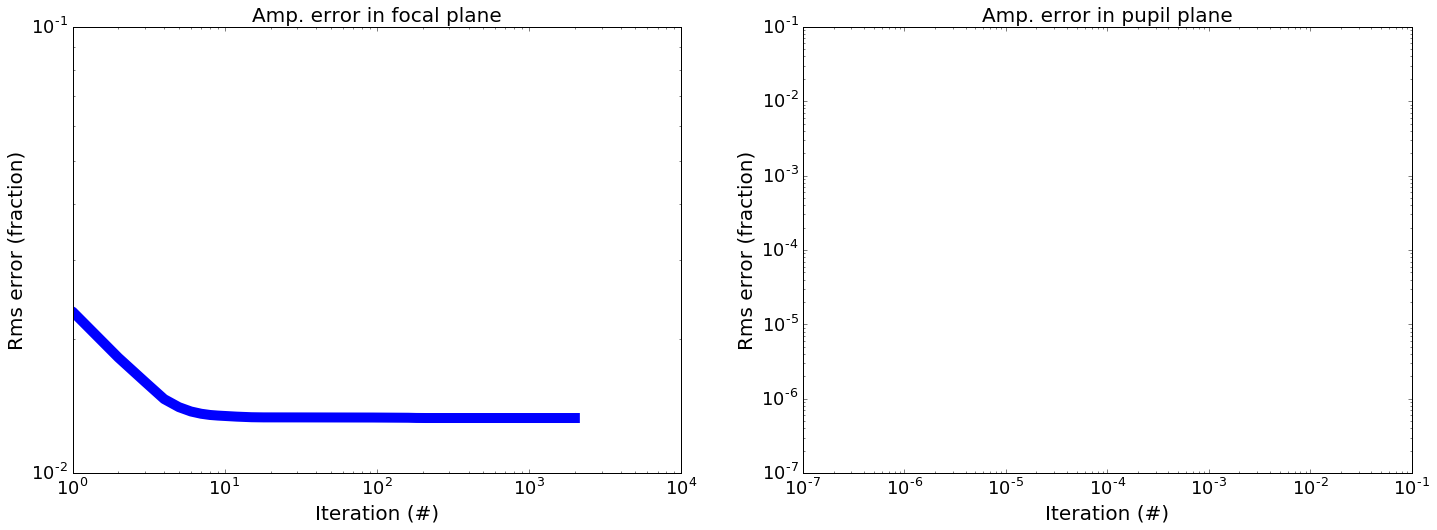

In [425]:
plot_errlist(no_aber_ori_errlist,no_aber_ori_errpuplist)

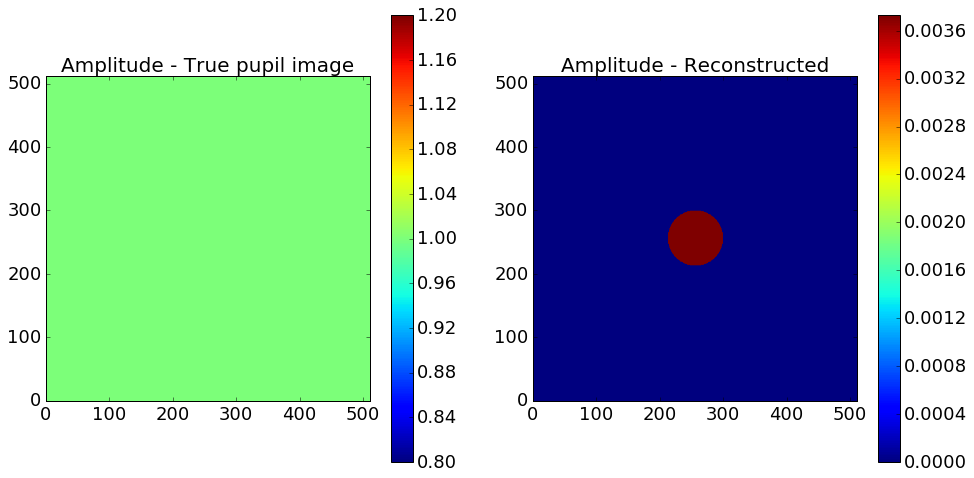

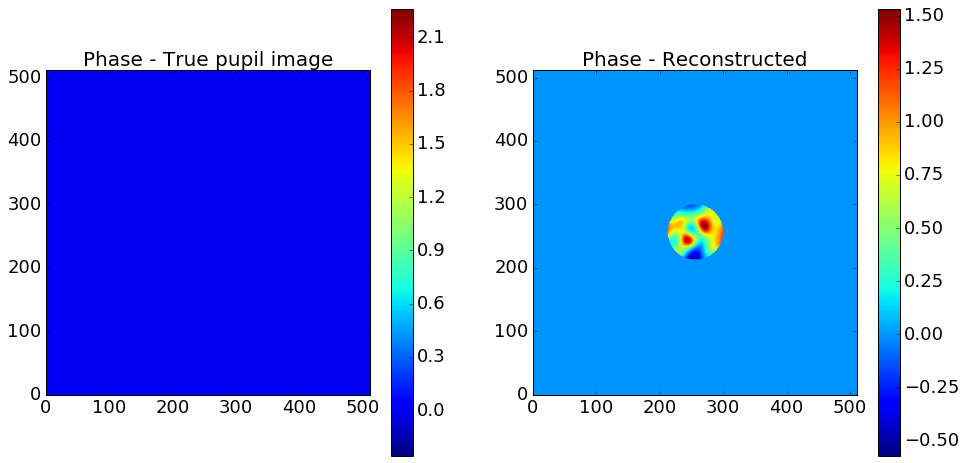

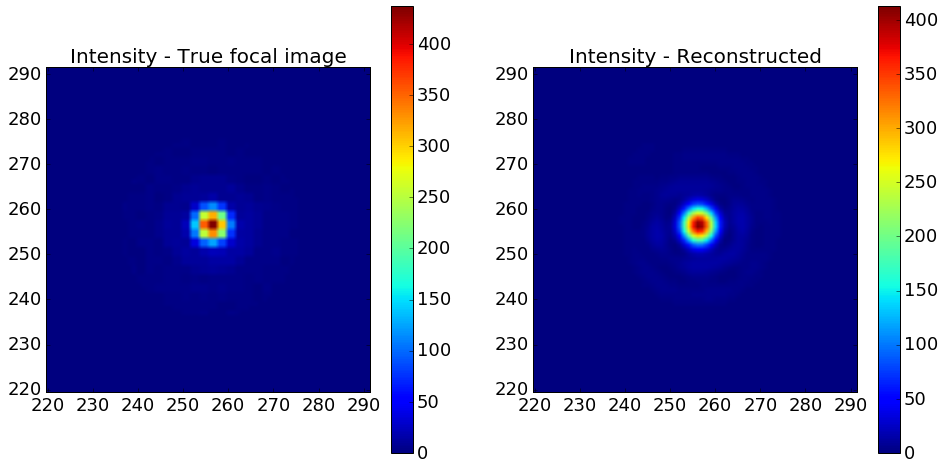

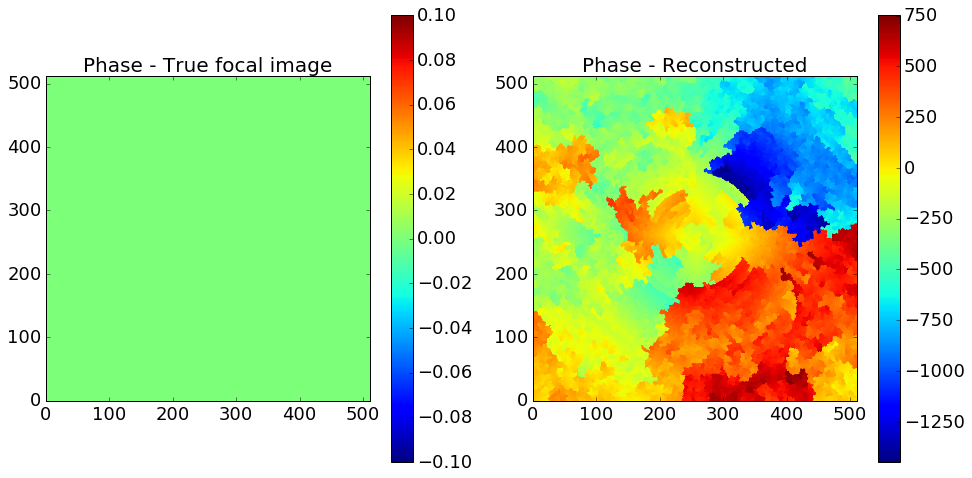

In [426]:
plot_recon(np.ones((Npix,Npix)),np.sqrt(no_aber_ori_PR.foc),no_aber_ori_pup_proj,no_aber_ori_foc)

Oh, well, the binning did something bad?

#### 2. Plus 300

In [429]:
plus_300_ori_PR = PR(foc=plus_300_ori_clp,oversamp=oversamp)

Down-sampled array dimension is not even: 87 pix
 Changed to nearest oversamp: 2.91 that gives even-sized arrays


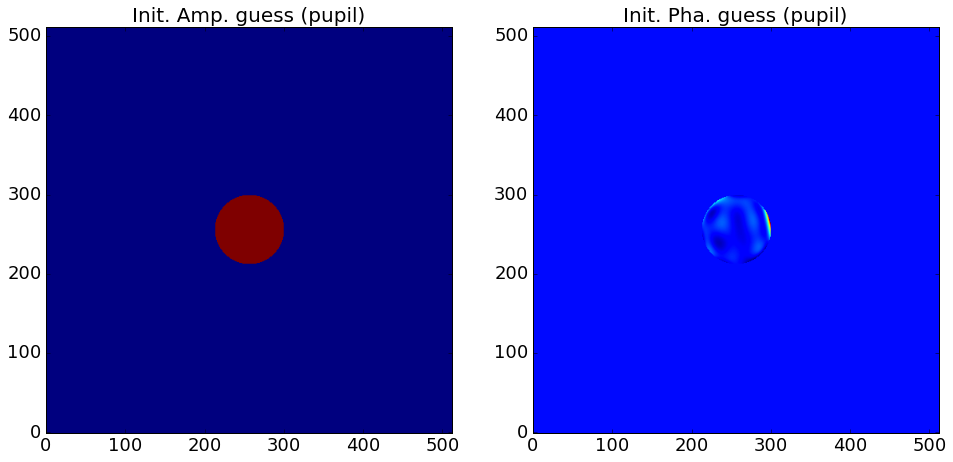

Current filter:


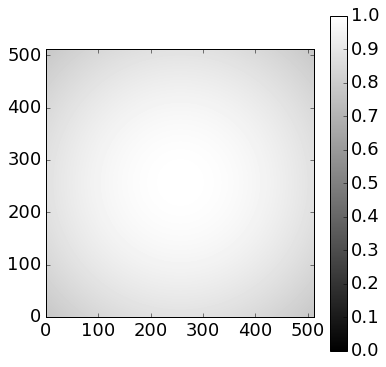

Current iter. : 100
        Error : 9.75e-03
Current iter. : 200
        Error : 9.75e-03
Current filter:


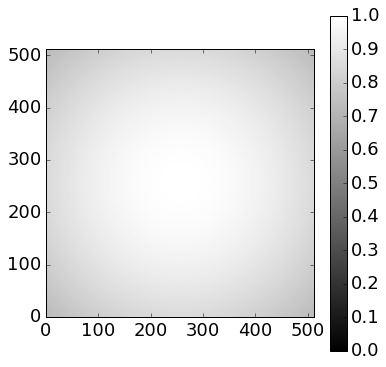

Current iter. : 300
        Error : 9.75e-03
Current iter. : 400
        Error : 9.75e-03
Current filter:


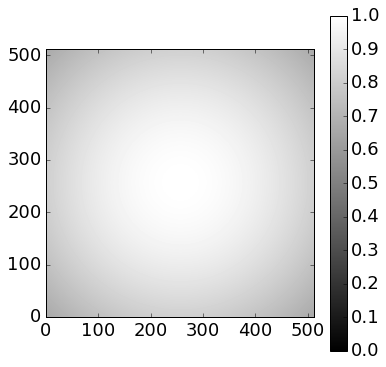

Current iter. : 500
        Error : 9.75e-03
Current iter. : 600
        Error : 9.75e-03
Current filter:


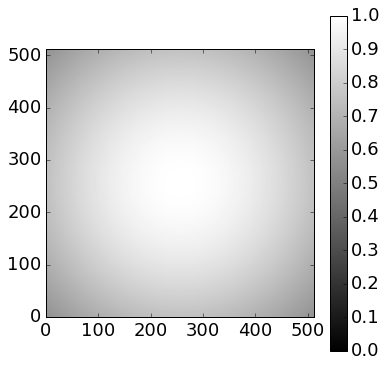

Current iter. : 700
        Error : 9.75e-03
Current iter. : 800
        Error : 9.75e-03
Current filter:


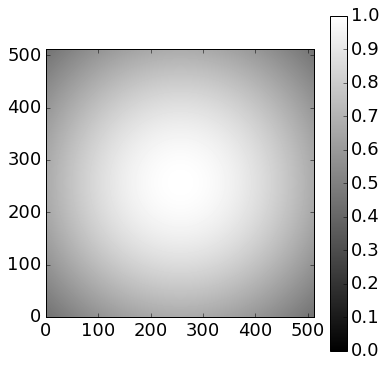

Current iter. : 900
        Error : 9.75e-03
Current iter. : 1000
        Error : 9.75e-03
Current filter:


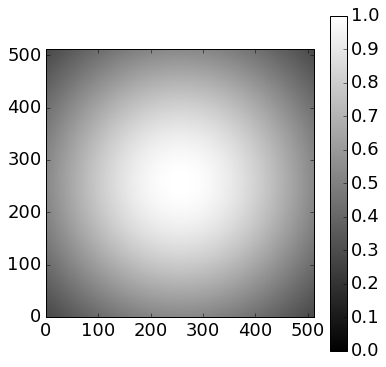

Current iter. : 1100
        Error : 9.75e-03
Current iter. : 1200
        Error : 9.75e-03
Current filter:


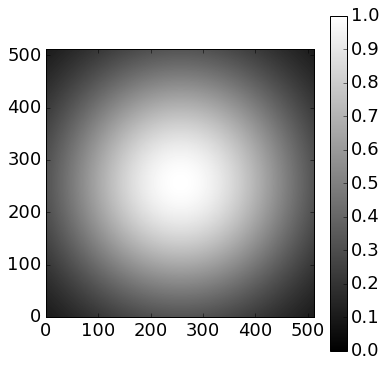

Current iter. : 1300
        Error : 9.75e-03
Current iter. : 1400
        Error : 9.75e-03
Current filter:


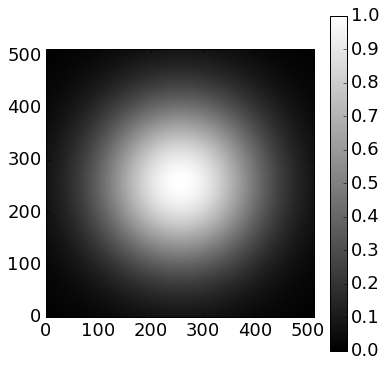

Current iter. : 1500
        Error : 9.75e-03
Current iter. : 1600
        Error : 9.75e-03
Current filter:


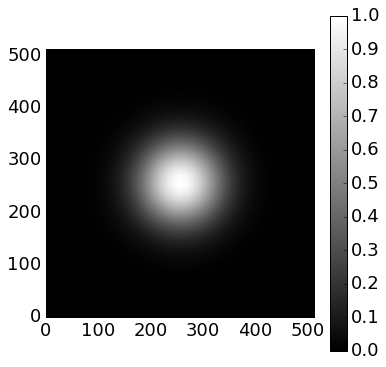

Current iter. : 1700
        Error : 9.75e-03
Current iter. : 1800
        Error : 9.75e-03
Current filter:


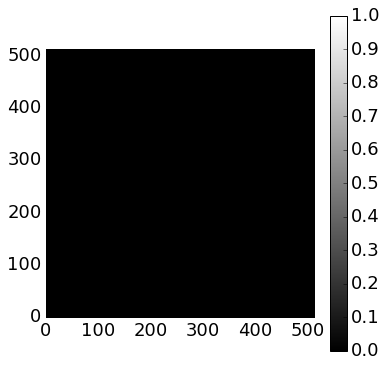

Current iter. : 1900
        Error : 9.75e-03
Current iter. : 2000
        Error : 9.75e-03
-----------------------
First iteration error: 3.03e-02
Final iteration : 2000
Final Error: 9.75e-03


In [430]:
plus_300_ori_pup,plus_300_ori_foc, \
plus_300_ori_errlist, \
plus_300_ori_pup_proj, \
plus_300_ori_errpuplist = plus_300_ori_PR.OSS(beta=0.5,force_only_phase=True,init='random')

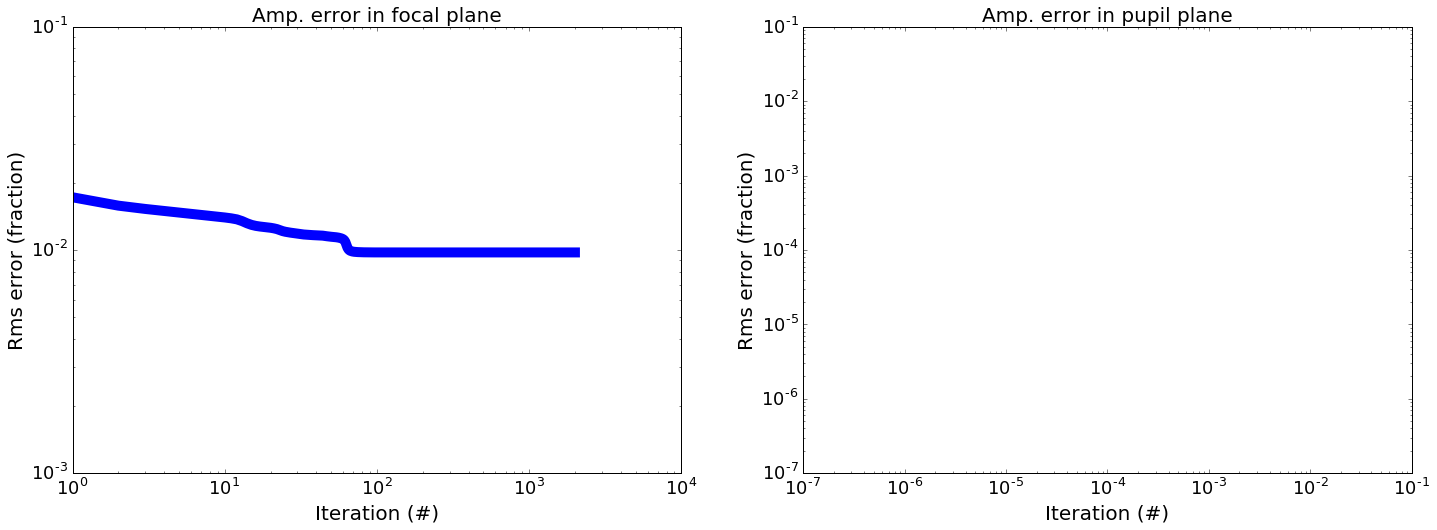

In [431]:
plot_errlist(plus_300_ori_errlist,plus_300_ori_errpuplist)

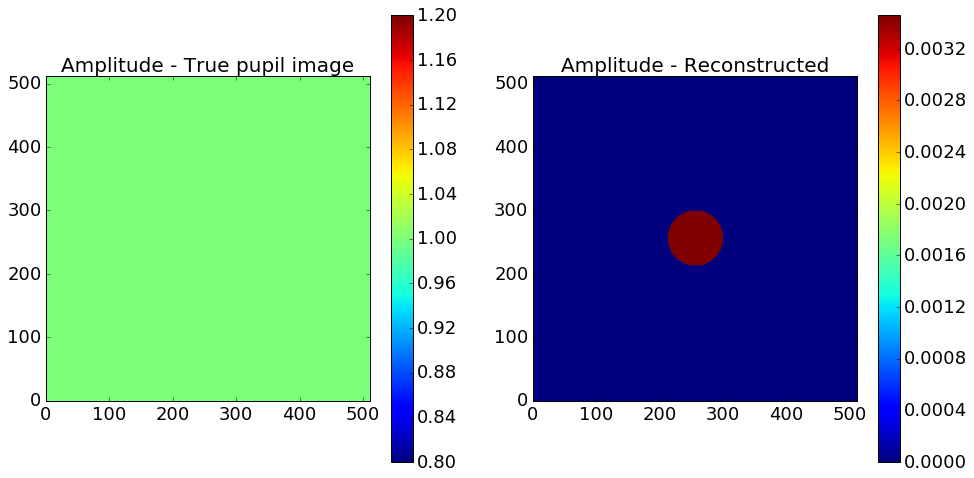

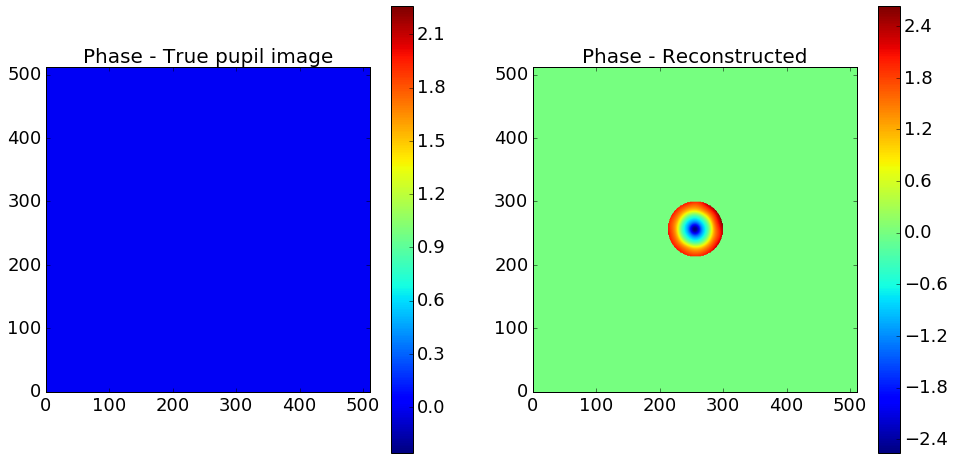

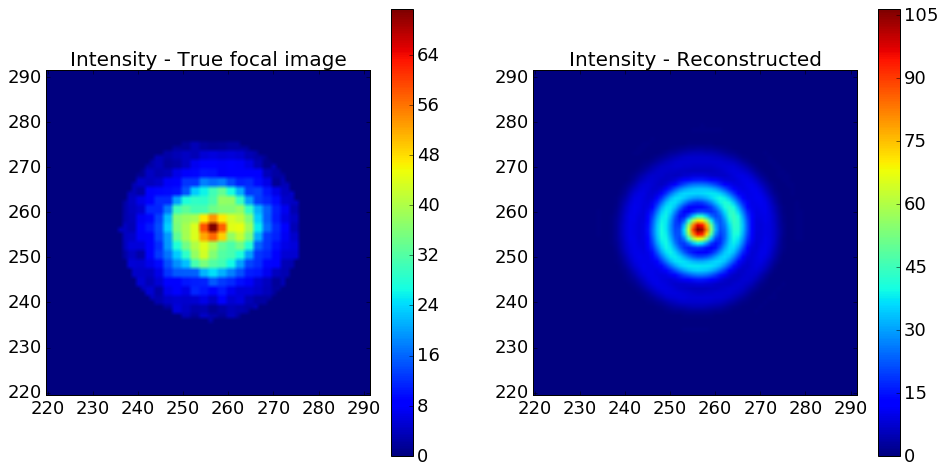

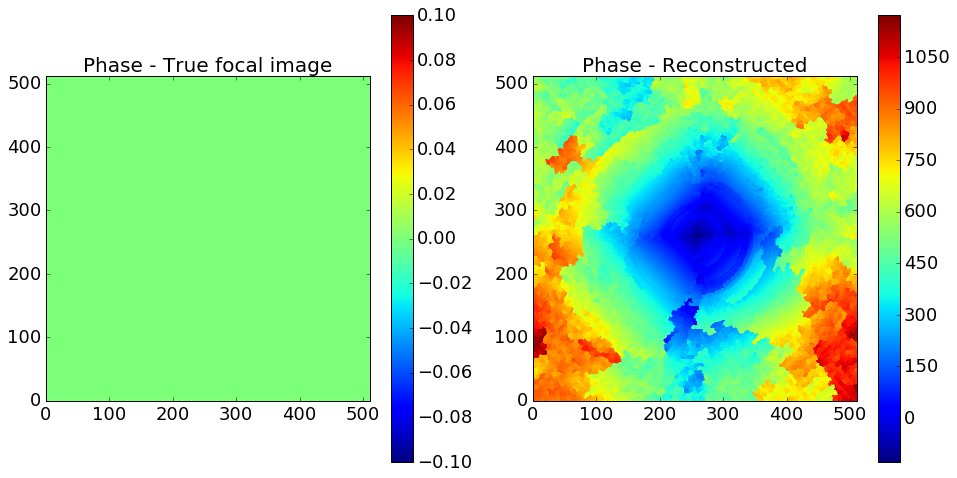

In [432]:
plot_recon(np.ones((Npix,Npix)),np.sqrt(plus_300_ori_PR.foc),plus_300_ori_pup_proj,plus_300_ori_foc)

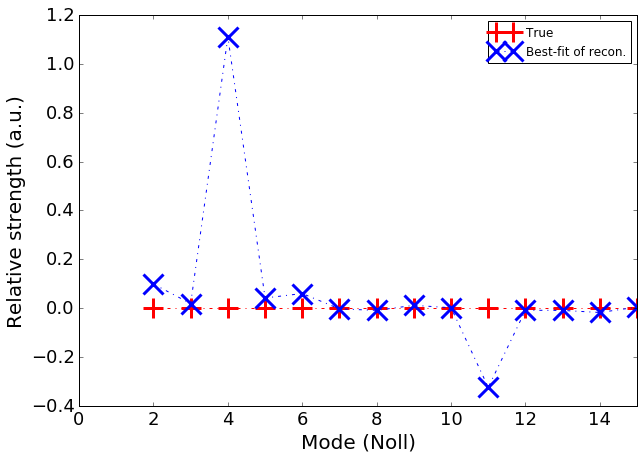

In [433]:
coef_plus_300_ori_true, \
coef_plus_300_ori_reco = wrap_up_zern_fit(plus_300_ori_PR,
                                          Recon_phasor=plus_300_ori_pup_proj,
                                          P_phasor=np.zeros((512,512)),
                                          oversamp=2.90)

#### 3. Ast. 150

In [434]:
ast_150_ori_PR = PR(foc=ast_150_ori_clp,oversamp=oversamp)

Down-sampled array dimension is not even: 87 pix
 Changed to nearest oversamp: 2.91 that gives even-sized arrays


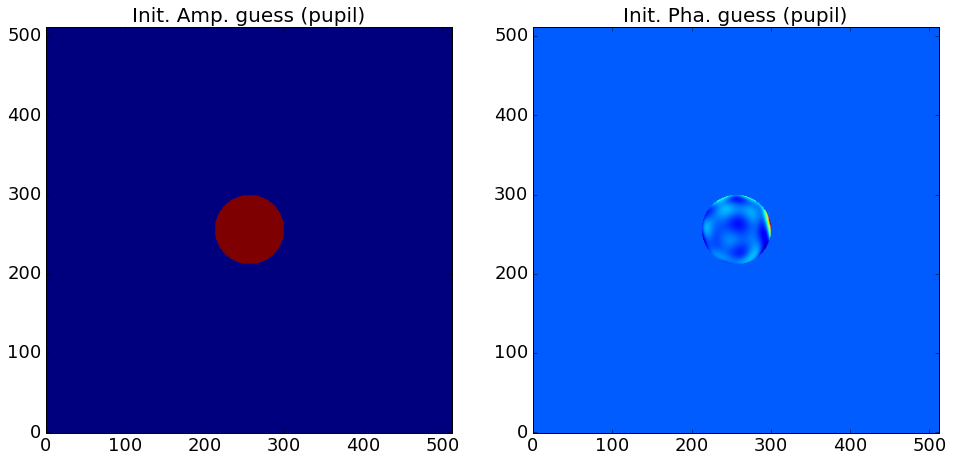

Current filter:


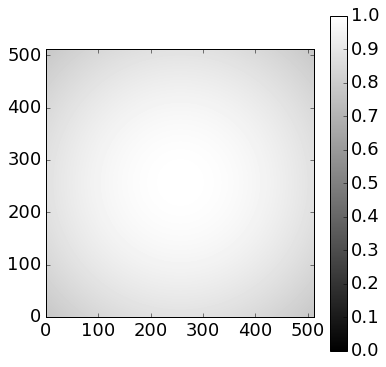

Current iter. : 100
        Error : 1.17e-02
Current iter. : 200
        Error : 1.17e-02
Current filter:


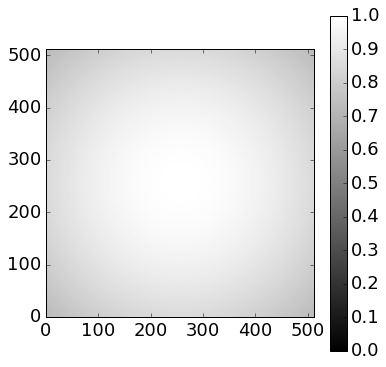

Current iter. : 300
        Error : 1.17e-02
Current iter. : 400
        Error : 1.16e-02
Current filter:


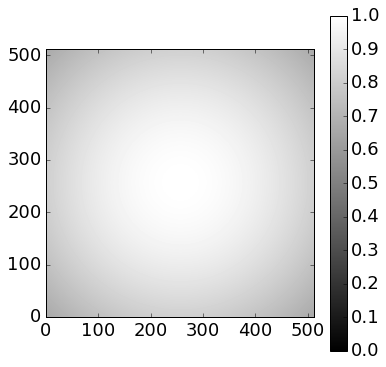

Current iter. : 500
        Error : 1.16e-02
Current iter. : 600
        Error : 1.16e-02
Current filter:


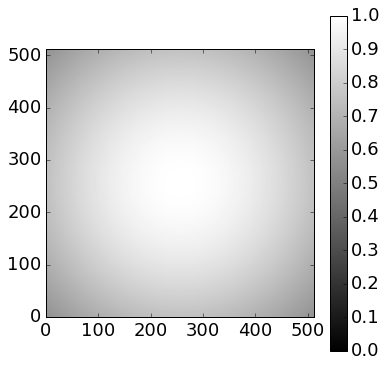

Current iter. : 700
        Error : 1.16e-02
Current iter. : 800
        Error : 1.16e-02
Current filter:


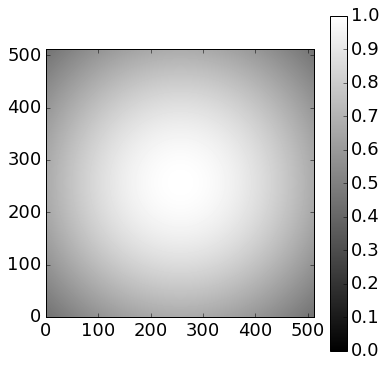

Current iter. : 900
        Error : 1.16e-02
Current iter. : 1000
        Error : 1.16e-02
Current filter:


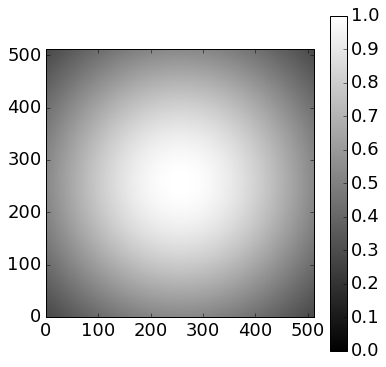

Current iter. : 1100
        Error : 1.16e-02
Current iter. : 1200
        Error : 1.16e-02
Current filter:


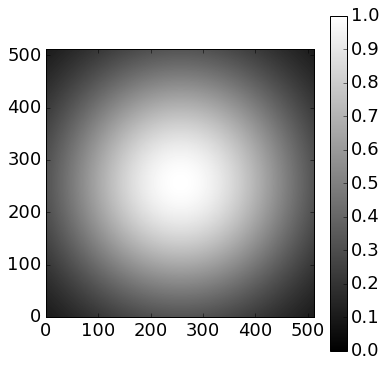

Current iter. : 1300
        Error : 1.16e-02
Current iter. : 1400
        Error : 1.16e-02
Current filter:


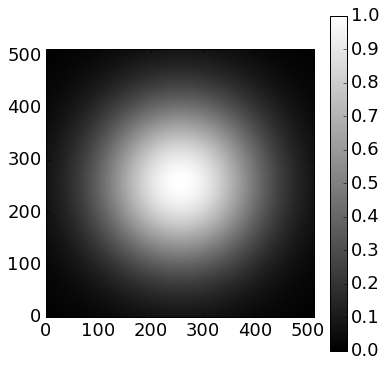

Current iter. : 1500
        Error : 1.16e-02
Current iter. : 1600
        Error : 1.16e-02
Current filter:


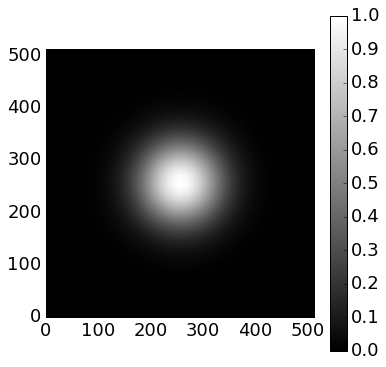

Current iter. : 1700
        Error : 1.16e-02
Current iter. : 1800
        Error : 1.16e-02
Current filter:


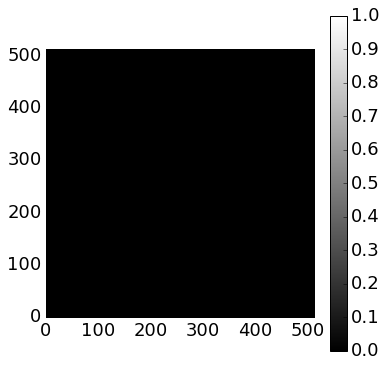

Current iter. : 1900
        Error : 1.16e-02
Current iter. : 2000
        Error : 1.16e-02
-----------------------
First iteration error: 3.52e-02
Final iteration : 2000
Final Error: 1.16e-02


In [435]:
ast_150_ori_pup,ast_150_ori_foc, \
ast_150_ori_errlist, \
ast_150_ori_pup_proj, \
ast_150_ori_errpuplist = ast_150_ori_PR.OSS(beta=0.5,force_only_phase=True,init='random')

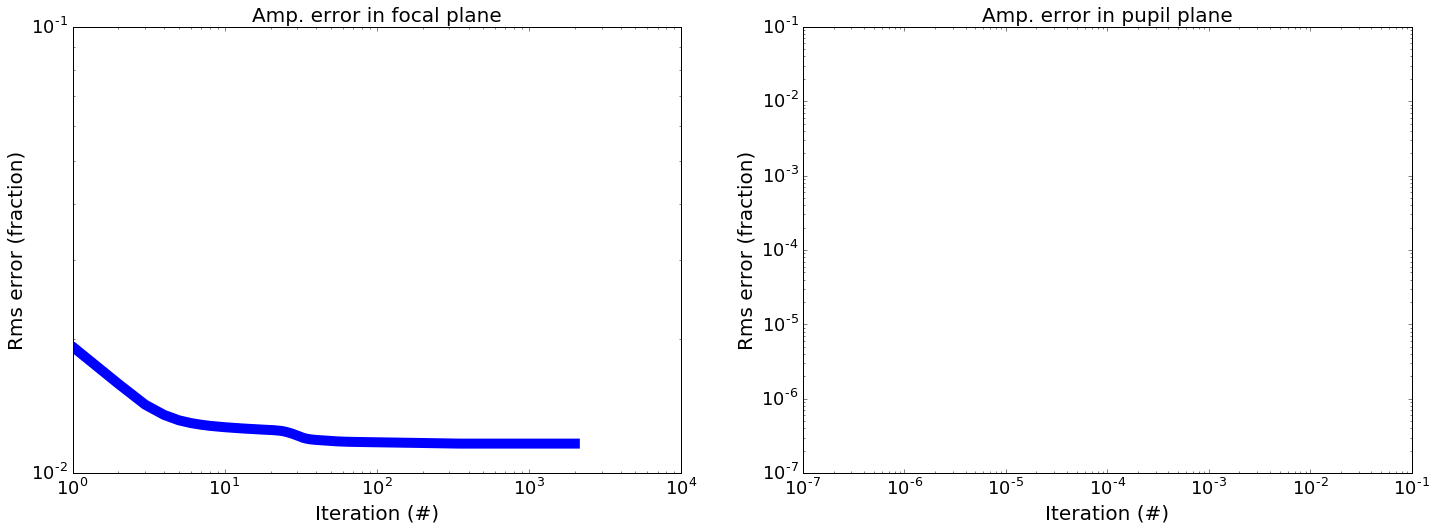

In [436]:
plot_errlist(ast_150_ori_errlist,ast_150_ori_errpuplist)

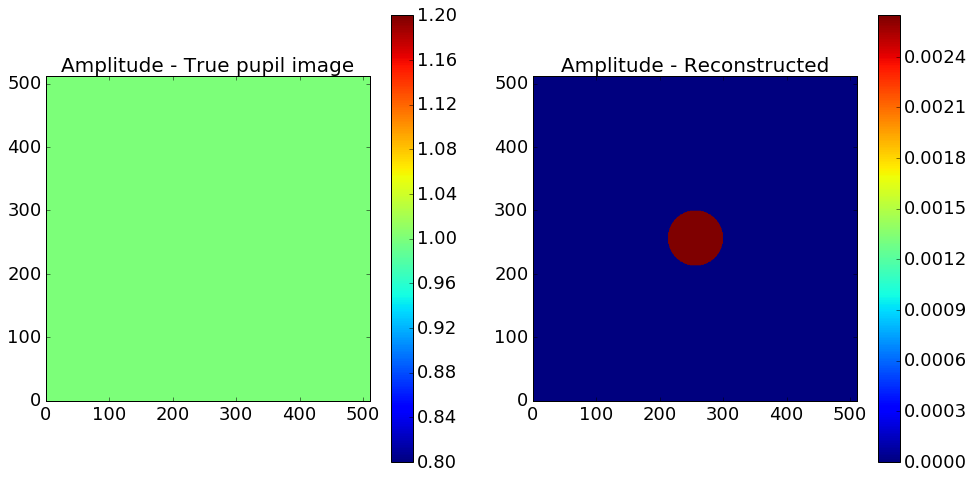

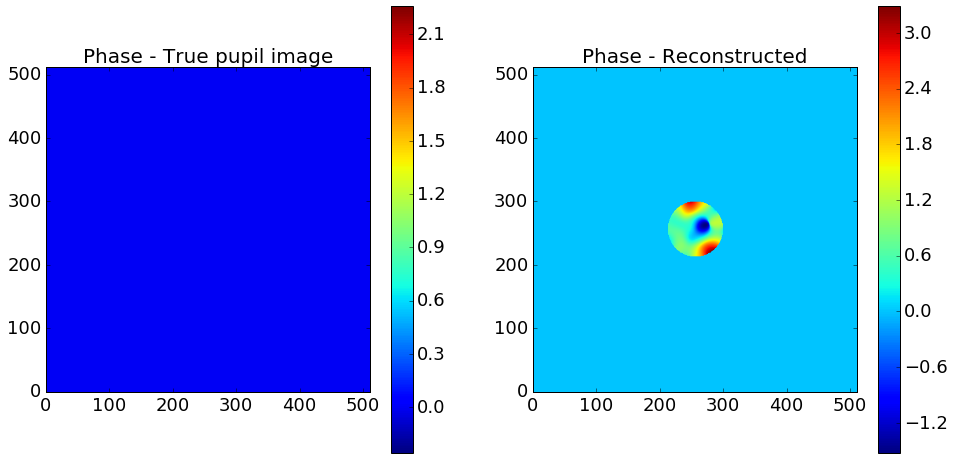

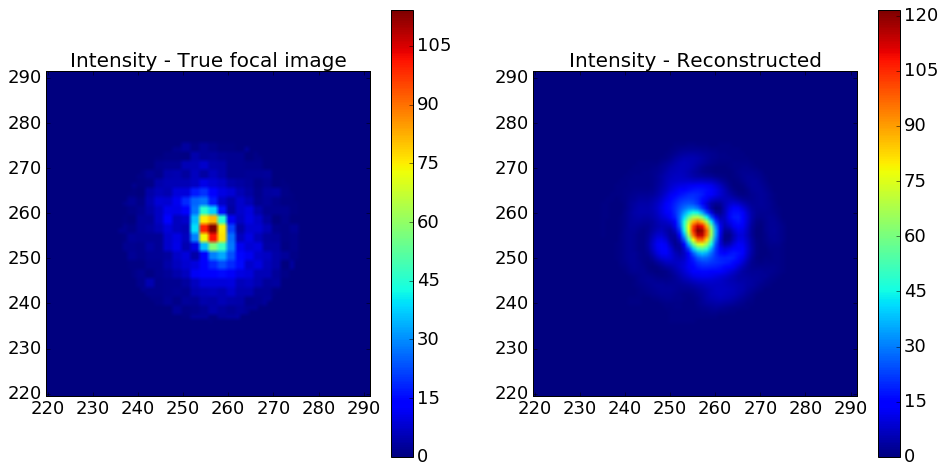

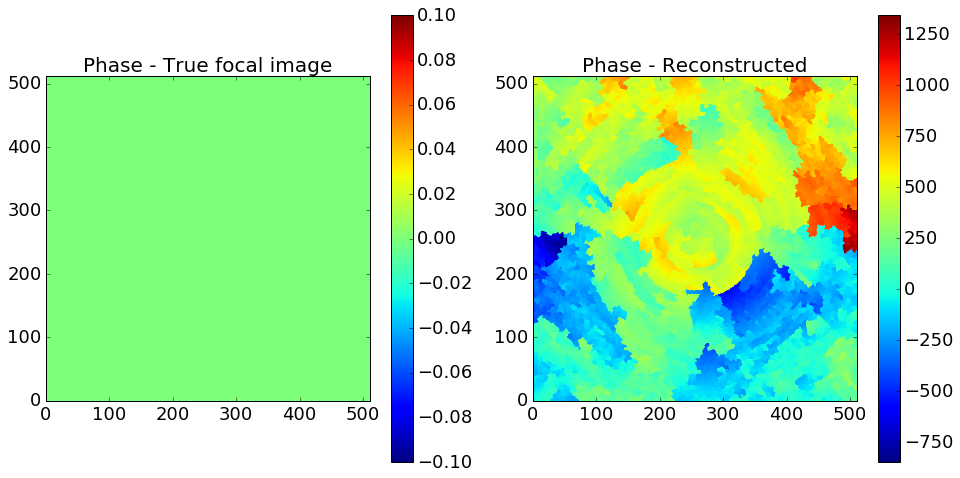

In [437]:
plot_recon(np.ones((Npix,Npix)),np.sqrt(ast_150_ori_PR.foc),ast_150_ori_pup_proj,ast_150_ori_foc)

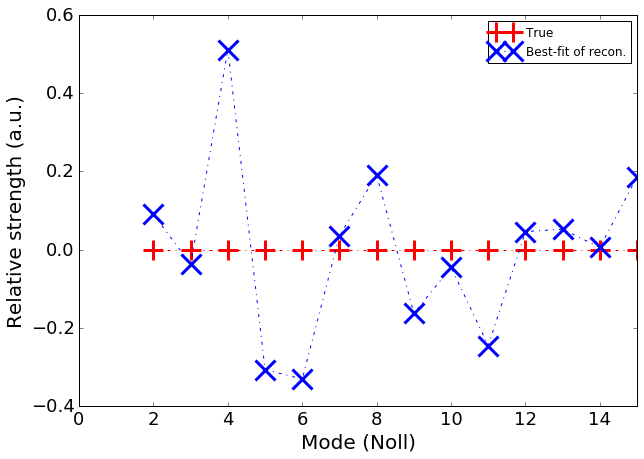

In [438]:
coef_ast_ori_150_true, \
coef_ast_ori_150_reco = wrap_up_zern_fit(ast_150_ori_PR,
                                         Recon_phasor=ast_150_ori_pup_proj,
                                         P_phasor=np.zeros((512,512)),
                                         oversamp=2.90)

----
#### <font color="magenta">Check 1</font>
Making sure that the "-150nm" one is the closest to "no aberration"

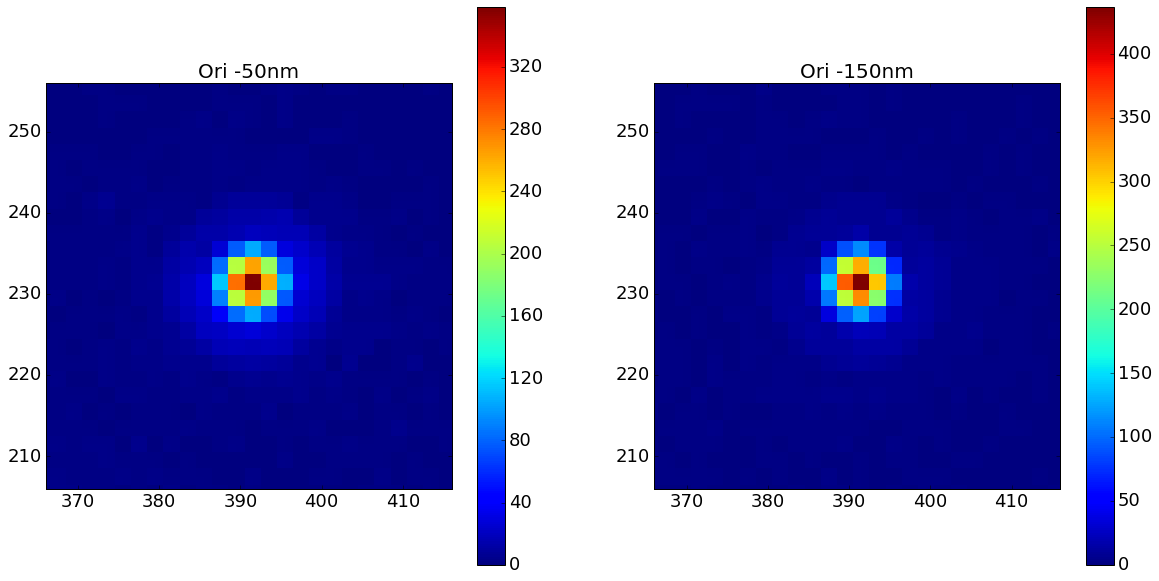

In [122]:
plt.figure(figsize=(20,10))
plt.subplot(121); plt.title('Ori -50nm')
plt.imshow(plus_100.data,origin='lower',interpolation='none')
plt.xlim(366,416); plt.ylim(206,256); 
plt.colorbar(); plt.clim(0,np.nanmax(plus_100.data))

plt.subplot(122); plt.title('Ori -150nm')
plt.imshow(no_aber.data,origin='lower',interpolation='none')
plt.xlim(366,416); plt.ylim(206,256); 
plt.colorbar(); plt.clim(0,np.nanmax(no_aber.data))